# EDA: Mental Health Risk & Disclosure (OSMI Tech Survey

## Problem Statement
How can tech companies identify which groups of employees are at highest risk for mental health challenges post-pandemic, **predict their likelihood of disclosure**, and **design targeted wellness interventions**—while safeguarding privacy and overcoming stigma?

**Success Criteria**
- Build a disclosure prediction model with ≥75% accuracy (later steps).  
- Identify 3–5 actionable **employee personas** based on risk & disclosure likelihood.  
- Deliver dashboards for HR to explore patterns by demographics, benefits, and culture.

This notebook performs **Exploratory Data Analysis (EDA)** to find the strongest drivers of:
- **(A) Mental health condition / treatment** (risk proxy)  
- **(B) Willingness to disclose** (disclosure proxy)



# Setup & Load

In [134]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


data_path_candidates = [
    Path("survey_clean_final.csv"),
    Path("survey_clean.csv"),
    Path("survey.csv"),
    Path("/mnt/data/survey.csv")
]


for p in data_path_candidates:
    if p.exists():
        data_path = p
        break
else:
    raise FileNotFoundError("Could not find a survey CSV. Put it next to this notebook or update data_path.")

df = pd.read_csv(data_path, low_memory=False)
print("Loaded:", data_path.resolve())
print("Shape:", df.shape)
df.head(10)

Loaded: /Users/mariaalejandrasuarez/Documents/Capstone 3/survey_clean_final.csv
Shape: (1259, 27)


,timestamp,age,gender,country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31+00:00,37.0,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37+00:00,44.0,Male,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44+00:00,32.0,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46+00:00,31.0,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22+00:00,31.0,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
5,2014-08-27 11:31:22+00:00,33.0,Male,United States,TN,NaN,Yes,No,Sometimes,6-25,...,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,NaN
6,2014-08-27 11:31:50+00:00,35.0,Female,United States,MI,NaN,Yes,Yes,Sometimes,1-5,...,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No,NaN
7,2014-08-27 11:32:05+00:00,39.0,Male,Canada,NaN,NaN,No,No,Never,1-5,...,Don't know,No,No,No,No,No,No,No,No,NaN
8,2014-08-27 11:32:39+00:00,42.0,Female,United States,IL,NaN,Yes,Yes,Sometimes,100-500,...,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No,NaN
9,2014-08-27 11:32:43+00:00,23.0,Male,Canada,NaN,NaN,No,No,Never,26-100,...,Don't know,No,No,Yes,Yes,Maybe,Maybe,Yes,No,NaN


## Ensure readable column names

In [135]:
def clean_colname(c):
    c = str(c).strip().lower()
    c = c.replace("/", " ").replace("\n", " ").replace("-", " ")
    c = " ".join(c.split())
    c = c.replace("%", "pct")
    c = "".join(ch if ch.isalnum() or ch==" " else "_" for ch in c)
    c = "_".join(c.split())
    while "__" in c:
        c = c.replace("__", "_")
    return c

orig = df.columns.tolist()
df.columns = [clean_colname(c) for c in df.columns]

print("Columns cleaned. Example mapping (first 10):")
for o, n in zip(orig[:10], df.columns[:10]):
    print(f"  {o} -> {n}")

Columns cleaned. Example mapping (first 10):
  timestamp -> timestamp
  age -> age
  gender -> gender
  country -> country
  state -> state
  self_employed -> self_employed
  family_history -> family_history
  treatment -> treatment
  work_interfere -> work_interfere
  no_employees -> no_employees


## Columns overview + set target

In [178]:
df.columns.tolist()

['timestamp',
 'Age',
 'Gender',
 'country',
 'state',
 'self_employed',
 'family_history',
 'treatment',
 'work_interfere',
 'no_employees',
 'remote_work',
 'tech_company',
 'benefits',
 'care_options',
 'wellness_program',
 'seek_help',
 'anonymity',
 'leave',
 'mental_health_consequence',
 'phys_health_consequence',
 'coworkers',
 'supervisor',
 'mental_health_interview',
 'phys_health_interview',
 'mental_vs_physical',
 'obs_consequence',
 'comments',
 'leave_ord',
 'work_interfere_ord',
 'age_bucket',
 'has_condition',
 'disclose_yes',
 'has_condition_bin',
 'disclose_yes_bin',
 'disclosure_risk_label']

In [137]:

TARGET_COL = None
for c in df.columns:
    if "disclos" in c.lower():
        TARGET_COL = c
        break

print("Detected target column:", TARGET_COL)

if TARGET_COL is not None:
    if df[TARGET_COL].dtype == object:
        mapping = {"yes":1, "y":1, "true":1, "1":1,
                   "no":0,  "n":0, "false":0, "0":0}
        df[TARGET_COL] = df[TARGET_COL].map(lambda x: mapping.get(str(x).strip().lower(), np.nan))
    df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")
else:
    print("⚠️ No target column with 'disclos' in the name. Set TARGET_COL manually.")


Detected target column: None
⚠️ No target column with 'disclos' in the name. Set TARGET_COL manually.


#### Standardize key columns (Age, Gender names)

In [138]:

rename_map = {
    "age": "Age",
    "gender": "Gender",
    "no_employees": "no_employees",  
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})


In [171]:




print("Available columns:", df.columns.tolist())

candidates = ["disclose_yes_bin", "disclosure_yes_bin", "disclose_yes", "disclosure", 
              # Add more potential column names based on what's in your DataFrame
              "disclose", "disclosed", "disclosure_status"]

found = [c for c in candidates if c in df.columns]
assert found, "Could not find your disclosure target column."
DISCLOSE_YES_COL = found[0]


df[DISCLOSE_YES_COL] = df[DISCLOSE_YES_COL].map({"Yes":1,"No":0}).fillna(df[DISCLOSE_YES_COL]).astype(int)
df["disclosure_risk_label"] = (1 - df[DISCLOSE_YES_COL]).astype(int)
print(df[[DISCLOSE_YES_COL, "disclosure_risk_label"]].head())


Available columns: ['timestamp', 'Age', 'Gender', 'country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments', 'leave_ord', 'work_interfere_ord', 'age_bucket', 'has_condition', 'disclose_yes', 'has_condition_bin', 'disclose_yes_bin']
   disclose_yes_bin  disclosure_risk_label
0                 1                      0
1                 0                      1
2                 1                      0
3                 0                      1
4                 1                      0


In [140]:

def norm_yn(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if s in {"yes","y","true","1"}: return "Yes"
    if s in {"no","n","false","0"}: return "No"
    if "don" in s and "know" in s:  return "Don't know"
    if "not sure" in s:             return "Don't know"
    return x  # leave as-is otherwise

for col in ["benefits","anonymity","care_options","seek_help","remote_work",
            "coworkers","supervisor","wellness_program"]:
    if col in df.columns:
        df[col] = df[col].apply(norm_yn)


leave_order = ["Very easy","Somewhat easy","Neutral","Somewhat difficult","Very difficult"]
interfere_order = ["Never","Rarely","Sometimes","Often"]

def map_ord(x, order):
    try:
        return order.index(x) + 1  # 1..k
    except ValueError:
        return np.nan

if "leave" in df.columns:
    df["leave_ord"] = df["leave"].apply(lambda x: map_ord(x, leave_order))

if "work_interfere" in df.columns:
    df["work_interfere_ord"] = df["work_interfere"].apply(lambda x: map_ord(x, interfere_order))


In [141]:

assert "Age" in df.columns, "Age column not found."
df["age_bucket"] = pd.cut(
    df["Age"],
    bins=[0,24,34,44,54,64,120],
    labels=["18–24","25–34","35–44","45–54","55–64","65+"],
    right=True, include_lowest=True
)


In [142]:

size_order = ["1-5","6-25","26-100","100-500","500-1000","1000-5000","5000-10000","10000+"]
if "no_employees" in df.columns:
    df["no_employees"] = df["no_employees"].astype("category")
    present = [x for x in size_order if x in df["no_employees"].cat.categories]
    df["no_employees"] = pd.Categorical(df["no_employees"], categories=present, ordered=True)


## Locate key variables (risk & disclosure)

In [143]:
def find_cols(df, needles):
    found = {}
    for n in needles:
        matches = [c for c in df.columns if n in c]
        if matches: found[n] = matches
    return found

needles = [
    "treat", "diagnos", "mental", "condition",         # risk/condition
    "disclos", "supervisor", "coworker", "interview",   # disclosure intent
    "benefit", "care_option", "anonym", "seek", "leave",
    "no_employees", "company", "remote", "work",
    "age", "gender", "country"
]

found = find_cols(df, needles)
for k, v in found.items():
    print(f"{k:>12}: {v}")

       treat: ['treatment']
      mental: ['mental_health_consequence', 'mental_health_interview', 'mental_vs_physical']
  supervisor: ['supervisor']
    coworker: ['coworkers']
   interview: ['mental_health_interview', 'phys_health_interview']
     benefit: ['benefits']
 care_option: ['care_options']
      anonym: ['anonymity']
        seek: ['seek_help']
       leave: ['leave', 'leave_ord']
no_employees: ['no_employees']
     company: ['tech_company']
      remote: ['remote_work']
        work: ['work_interfere', 'remote_work', 'coworkers', 'work_interfere_ord']
         age: ['age_bucket']
     country: ['country']


## Missingness heatmap

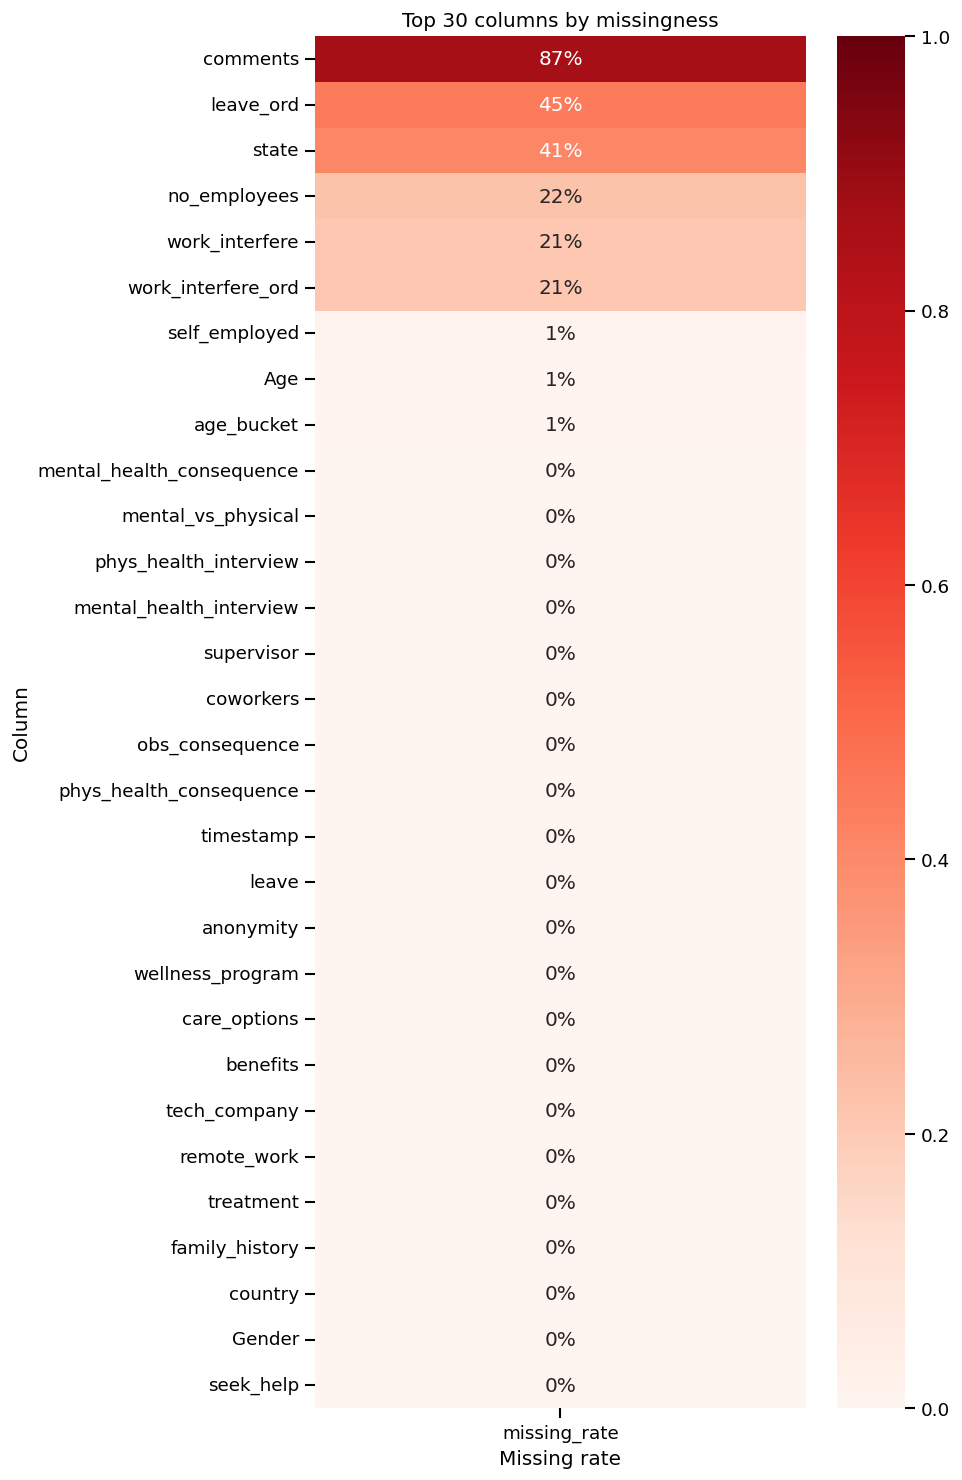

In [144]:

def missingness_heatmap(df, top_k=30):
    miss = df.isna().mean().sort_values(ascending=False)
    top = miss.head(top_k).to_frame("missing_rate").reset_index()
    plt.figure(figsize=(8, 0.35*len(top) + 2))
    
    # Fix: Use the actual column name from reset_index()
    # In newer pandas versions, the column is named 0 or we can specify a name
    sns.heatmap(top.set_index("index")[["missing_rate"]],  # Changed order of operations
                annot=True, vmin=0, vmax=1, cbar=True, fmt=".0%", cmap="Reds")
    
    plt.title(f"Top {len(top)} columns by missingness")
    plt.ylabel("Column"); plt.xlabel("Missing rate")
    plt.tight_layout(); plt.show()

missingness_heatmap(df, top_k=30)

## Create target proxies (risk & disclosure)

In [145]:
import numpy as np
import pandas as pd


YES = {"yes","y","true","t","1","1.0"}
NO  = {"no","n","false","f","0","0.0"}

def to_yes_no(x):
    """Map many truthy/falsy spellings to 'Yes'/'No'; keep common OSMI mid-answers."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in YES: return "Yes"
    if s in NO:  return "No"
    if s in {"maybe","some of them","depends","not sure","unsure"}:
        return s.title()  # 'Maybe', 'Some Of Them', 'Depends', 'Not Sure', 'Unsure'
    return str(x)  # keep original text if it's something else

def is_yes(x):
    if pd.isna(x): return False
    return str(x).strip().lower() in YES or str(x).strip().lower() == "yes"


cols_lc = {c.lower(): c for c in df.columns}
def has_col(substr):
    substr = substr.lower()
    return [orig for lc, orig in cols_lc.items() if substr in lc]


risk_candidates = []
for key in ["treat","diagnos","condition"]:
    risk_candidates += has_col(key)
risk_candidates = list(dict.fromkeys(risk_candidates))  # de-dup

risk_col = None
for c in risk_candidates:
    vals = df[c].dropna().astype(str).str.lower().unique()
    if any(v in YES or v in NO or v in {"yes","no"} for v in vals):
        risk_col = c
        break
if risk_col is None and risk_candidates:
    risk_col = risk_candidates[0]  # fallback: the first found

if risk_col is not None:
    df["has_condition"] = df[risk_col].map(to_yes_no)
else:
    df["has_condition"] = np.nan


disclose_cols = []
for key in ["supervisor","coworker","disclos","interview"]:
    disclose_cols += has_col(key)
disclose_cols = list(dict.fromkeys(disclose_cols))  # de-dup

if disclose_cols:
    any_yes = np.zeros(len(df), dtype=bool)
    for c in disclose_cols:
        any_yes |= df[c].apply(is_yes).fillna(False).to_numpy()
    df["disclose_yes"] = np.where(any_yes, "Yes", "No")
else:
    df["disclose_yes"] = np.nan


df["has_condition_bin"] = df["has_condition"].map({"Yes":1, "No":0})
df["disclose_yes_bin"] = df["disclose_yes"].map({"Yes":1, "No":0})


print("Risk proxy column used:", risk_col)
print("Disclosure-related columns used (up to 8 shown):", disclose_cols[:8])

print("\nhas_condition value counts:")
print(df["has_condition"].value_counts(dropna=False))

print("\ndisclose_yes value counts:")
print(df["disclose_yes"].value_counts(dropna=False))

print("\nCrosstab (rows=has_condition, cols=disclose_yes):")
print(pd.crosstab(df["has_condition"], df["disclose_yes"], dropna=False))



Risk proxy column used: treatment
Disclosure-related columns used (up to 8 shown): ['supervisor', 'coworkers', 'mental_health_interview', 'phys_health_interview']

has_condition value counts:
has_condition
Yes    637
No     622
Name: count, dtype: int64

disclose_yes value counts:
disclose_yes
No     633
Yes    626
Name: count, dtype: int64

Crosstab (rows=has_condition, cols=disclose_yes):
disclose_yes    No  Yes
has_condition          
No             312  310
Yes            321  316


## Distribution: has_condition

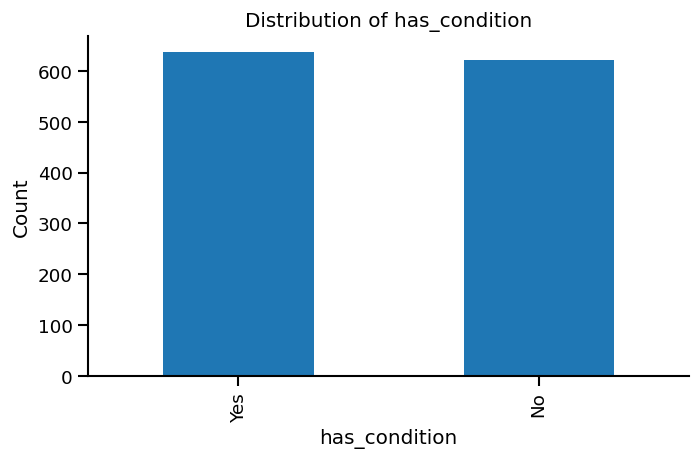

In [146]:
df["has_condition"].value_counts(dropna=False).plot(kind="bar", figsize=(6,4))
plt.title("Distribution of has_condition")
plt.xlabel("has_condition")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Distribution: disclose_yes

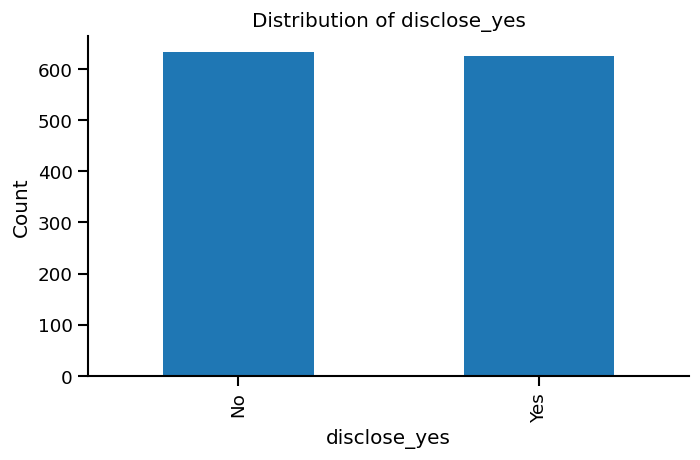

In [147]:
df["disclose_yes"].value_counts(dropna=False).plot(kind="bar", figsize=(6,4))
plt.title("Distribution of disclose_yes")
plt.xlabel("disclose_yes")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Overall rates of risk & disclosure

In [148]:
def pct_yes(series):
    vc = series.value_counts(dropna=True)
    yes = vc.get("Yes", 0)
    total = vc.sum()
    return round(100 * yes / total, 1) if total else np.nan

risk_rate = pct_yes(df["has_condition"])
disc_rate = pct_yes(df["disclose_yes"])

print(f"Estimated % with condition/treatment (risk proxy): {risk_rate}%")
print(f"Estimated % willing to disclose (any channel):   {disc_rate}%")

Estimated % with condition/treatment (risk proxy): 50.6%
Estimated % willing to disclose (any channel):   49.7%


### Proxy Targets: Summary Statistics

- **Estimated % with condition/treatment (Risk Proxy):** 50.6%  
- **Estimated % willing to disclose (Any Channel):** 49.7%

This indicates that while half of tech workers face mental health risk, only half feel comfortable disclosing it at work. 
This cultural gap is critical for organizations aiming to support employee well-being.


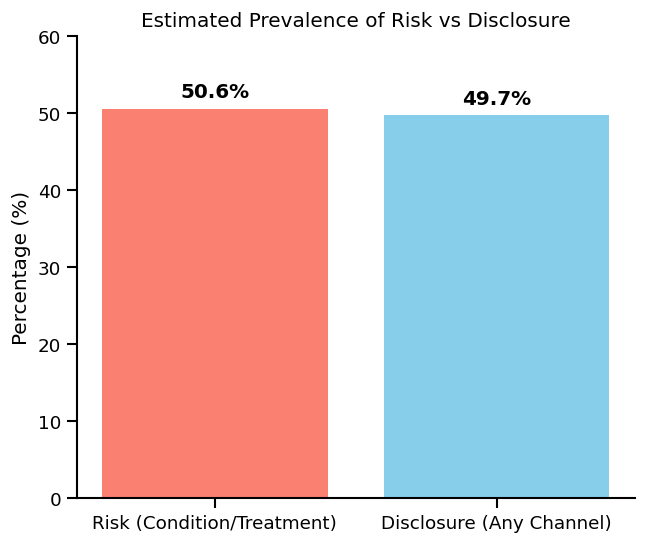

In [149]:
import matplotlib.pyplot as plt

proxies = {
    "Risk (Condition/Treatment)": 50.6,
    "Disclosure (Any Channel)": 49.7
}

fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(proxies.keys(), proxies.values(), color=["salmon","skyblue"])

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, 
            f"{height:.1f}%", ha="center", va="bottom", fontsize=12, fontweight="bold")

ax.set_title("Estimated Prevalence of Risk vs Disclosure")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 60)  # give space for labels

plt.show()


## Crosstab heatmap-like (counts)

disclose_yes    No  Yes
has_condition          
No             312  310
Yes            321  316


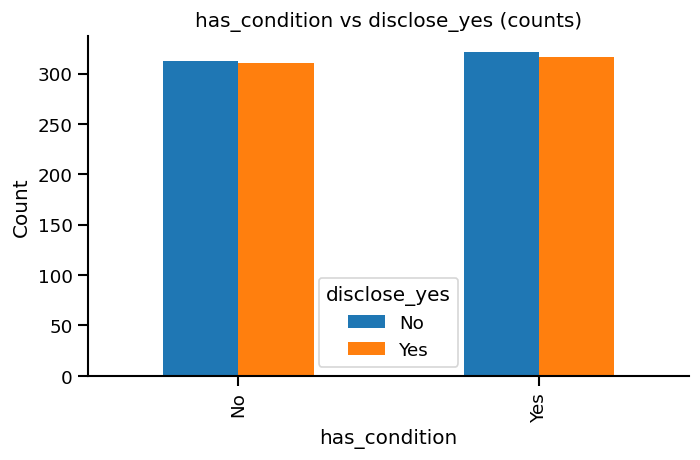

In [150]:
ct = pd.crosstab(df["has_condition"], df["disclose_yes"])
print(ct)
ct.plot(kind="bar", figsize=(6,4))
plt.title("has_condition vs disclose_yes (counts)")
plt.xlabel("has_condition")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## distribution + percent-stacked bars

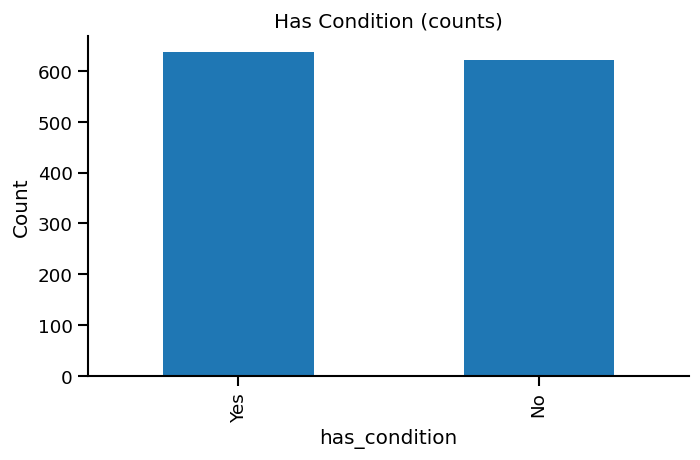

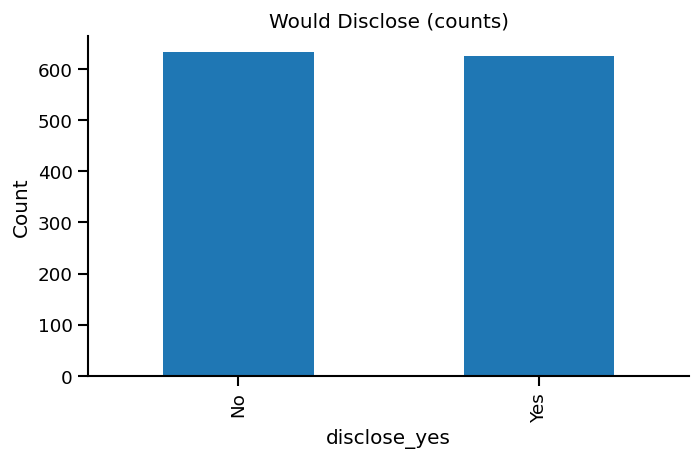

In [151]:
import matplotlib.pyplot as plt

df["has_condition"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Has Condition (counts)")
plt.xlabel("has_condition"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

df["disclose_yes"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Would Disclose (counts)")
plt.xlabel("disclose_yes"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

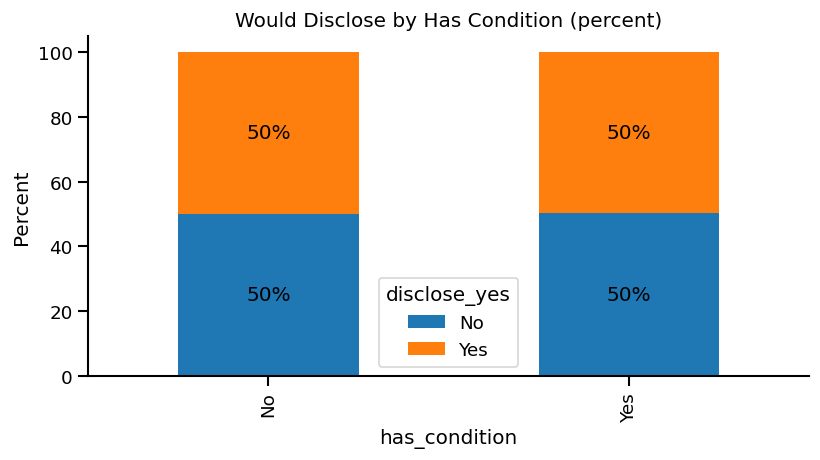

In [152]:

ct = pd.crosstab(df["has_condition"], df["disclose_yes"], normalize="index") * 100


ax = ct.plot(kind="bar", stacked=True, figsize=(7,4))
plt.title("Would Disclose by Has Condition (percent)")
plt.xlabel("has_condition"); plt.ylabel("Percent")
for c in ax.containers:
    ax.bar_label(c, fmt="%.0f%%", label_type="center")
plt.tight_layout(); plt.show()




=== benefits ===


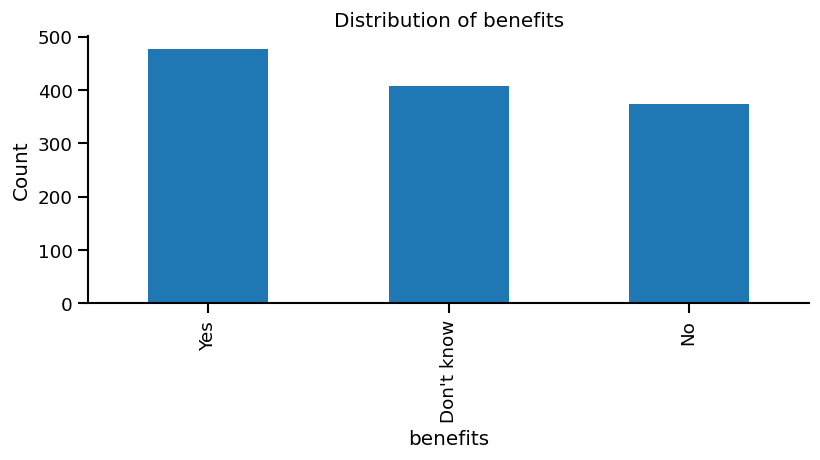

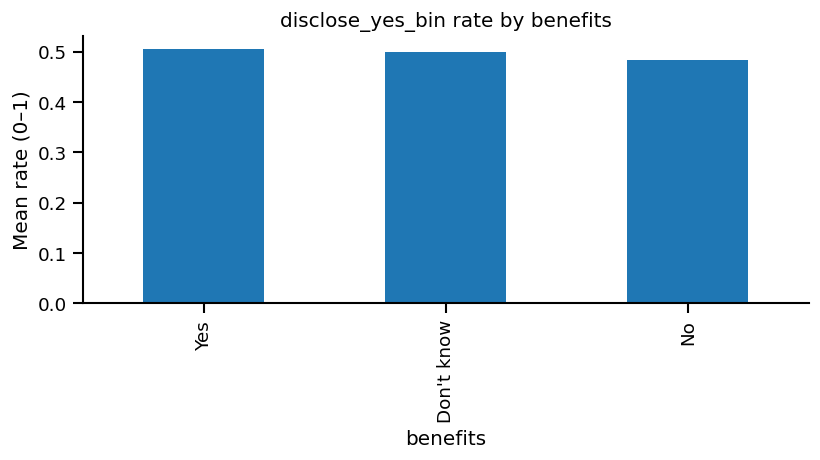


=== anonymity ===


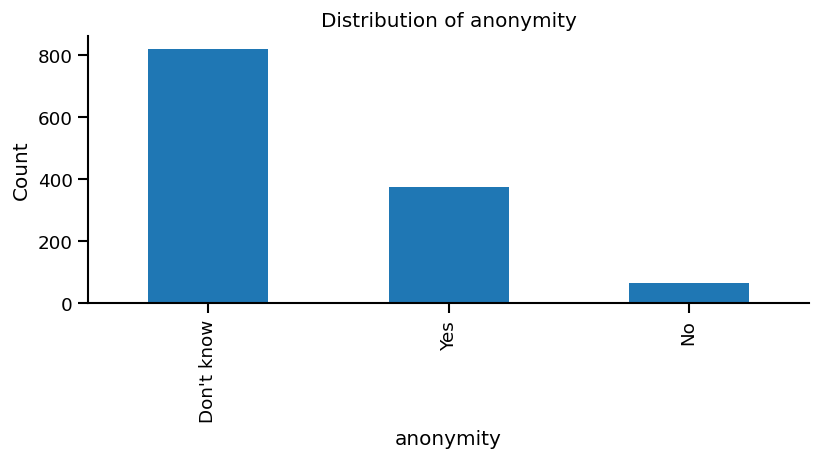

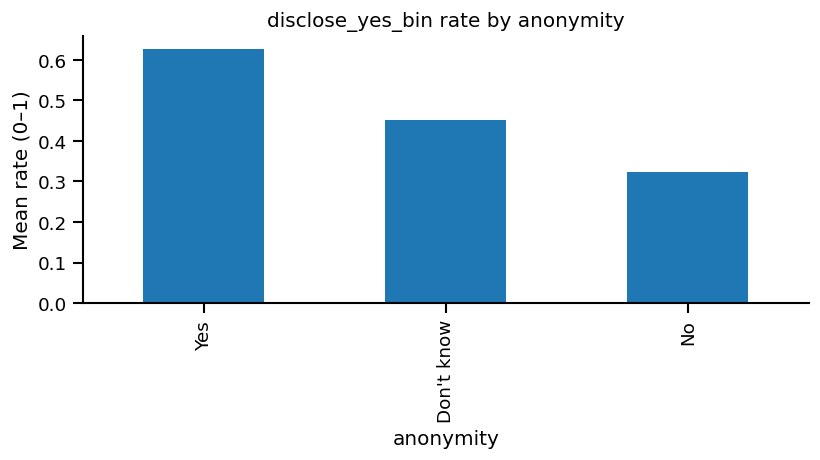


=== leave ===


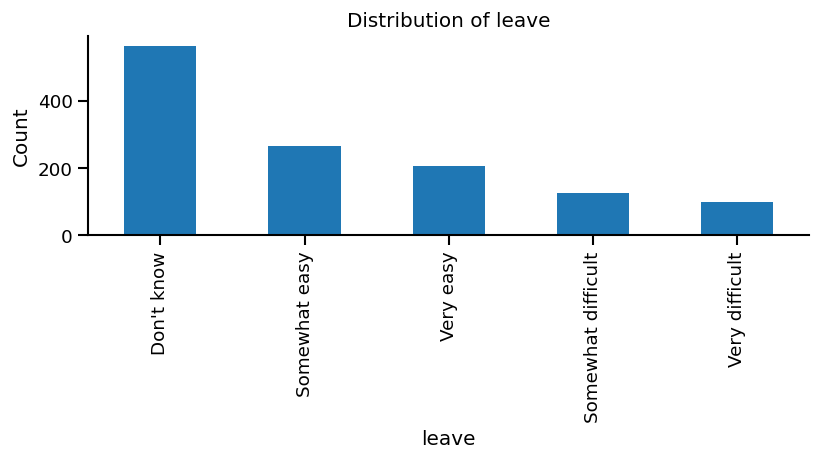

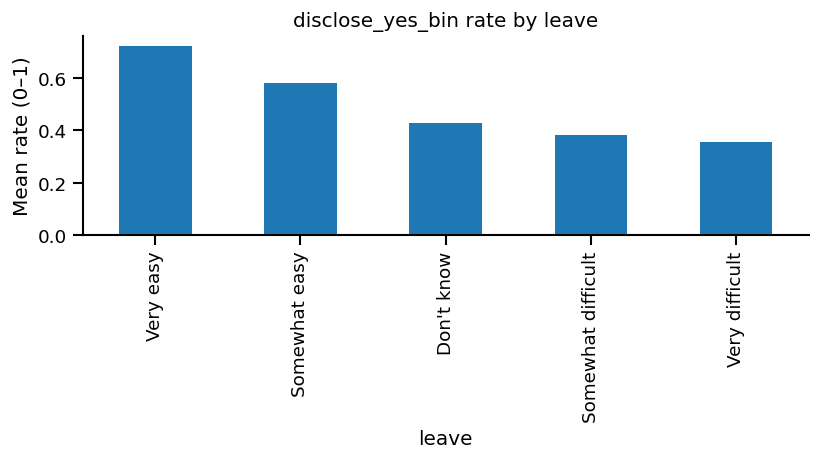


=== care_options ===


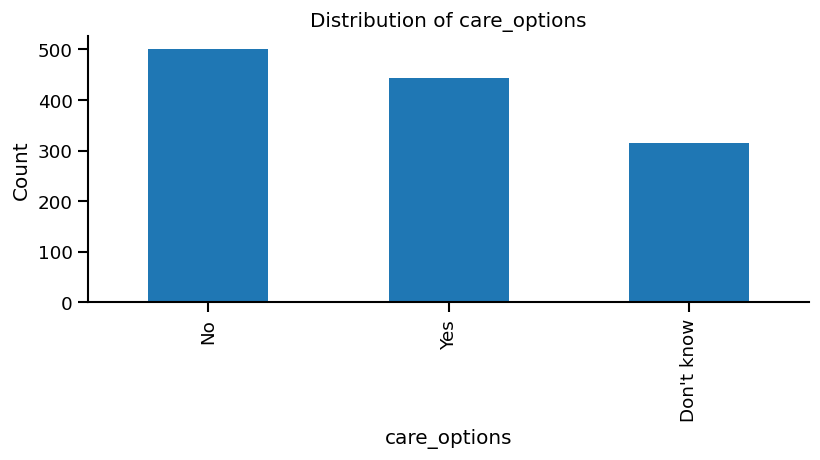

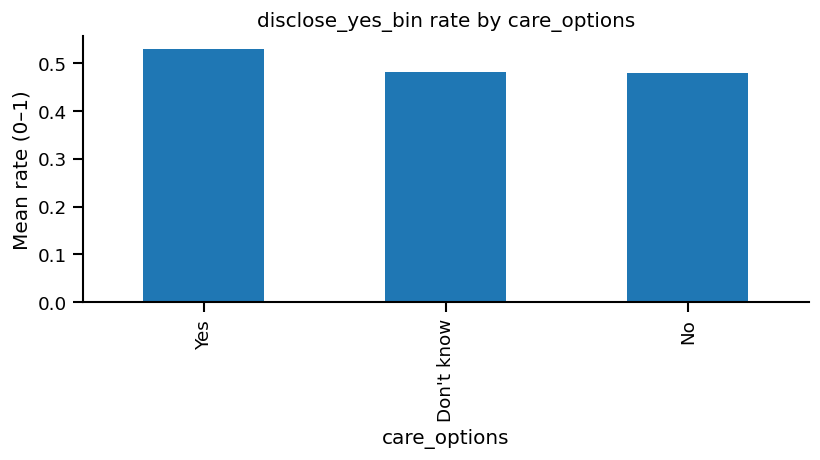


=== seek_help ===


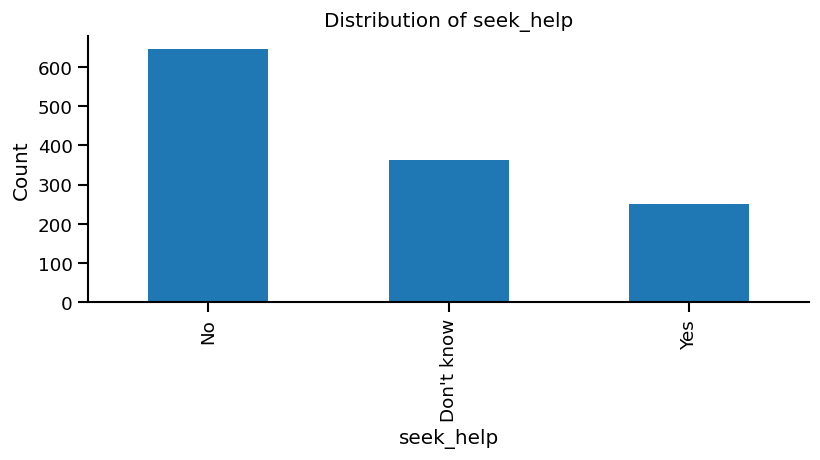

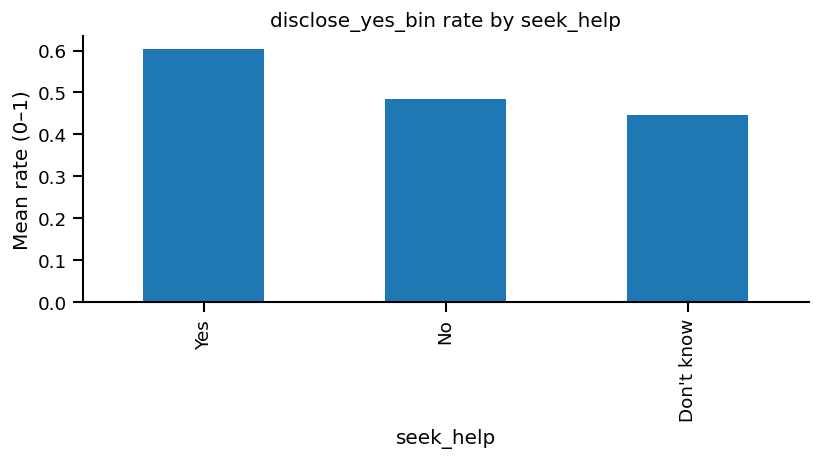


=== no_employees ===


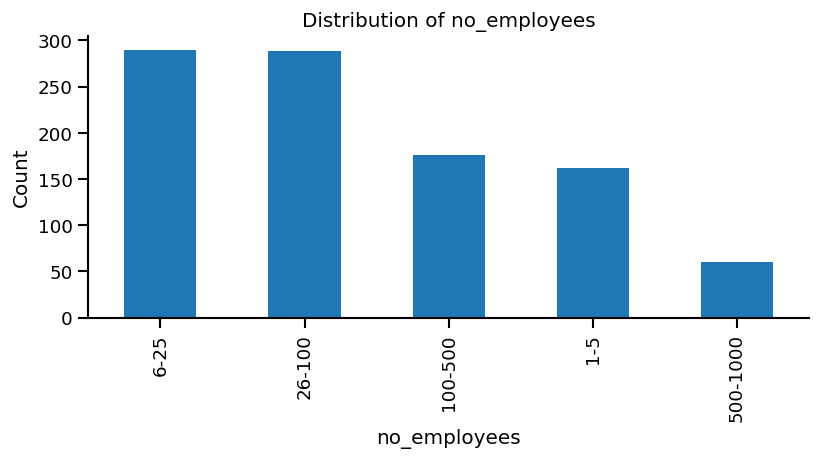

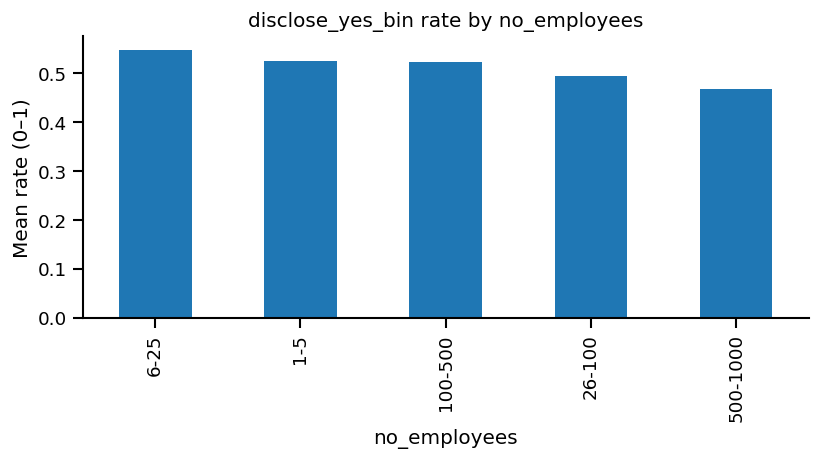


=== remote_work ===


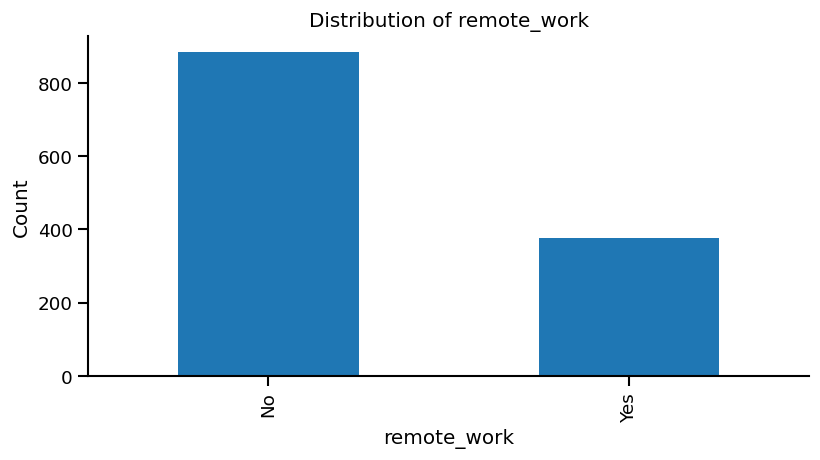

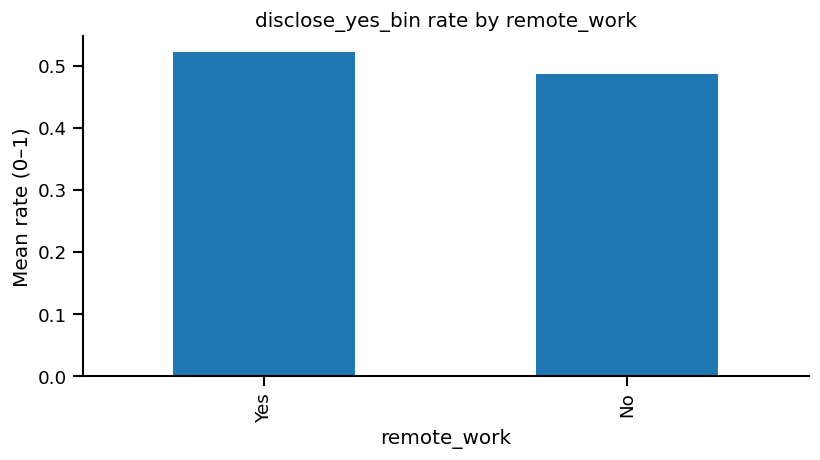


=== work_interfere ===


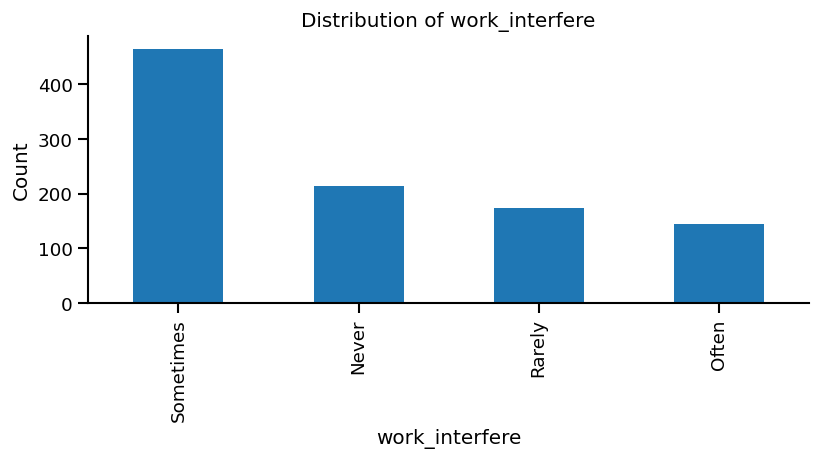

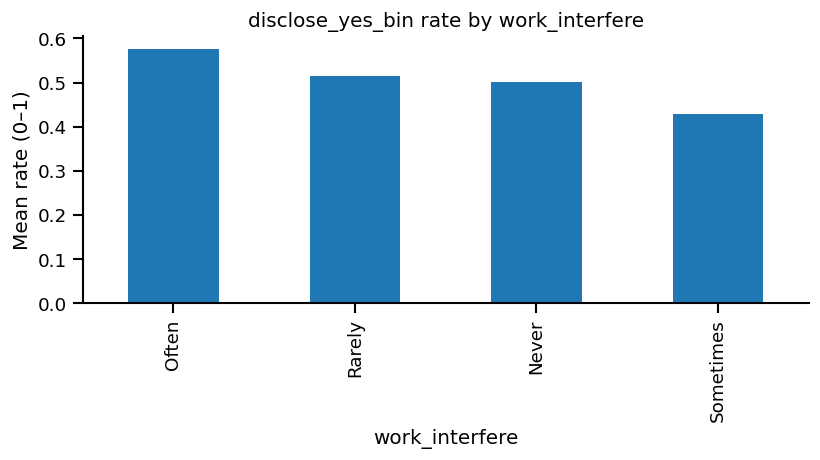


=== coworkers ===


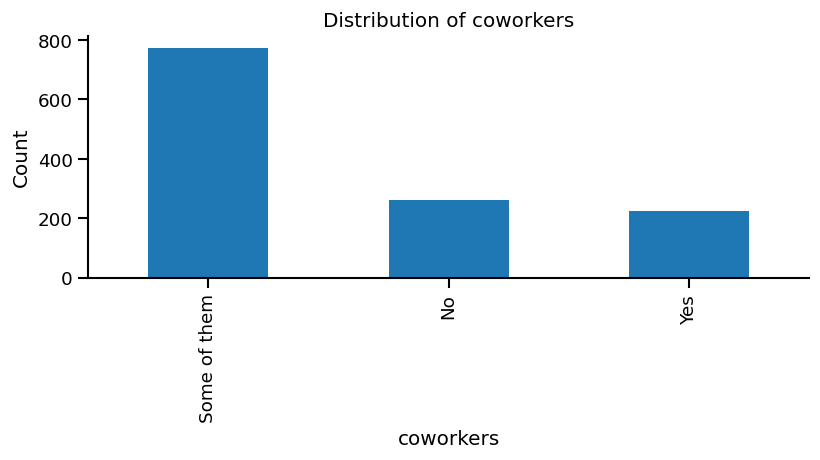

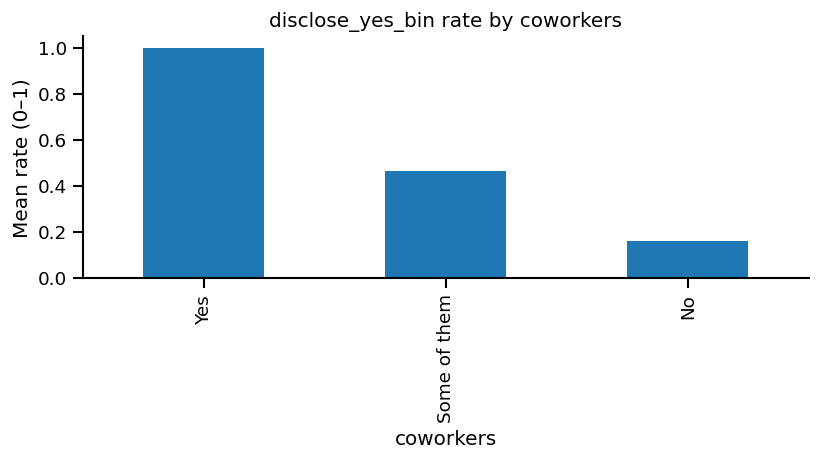


=== supervisor ===


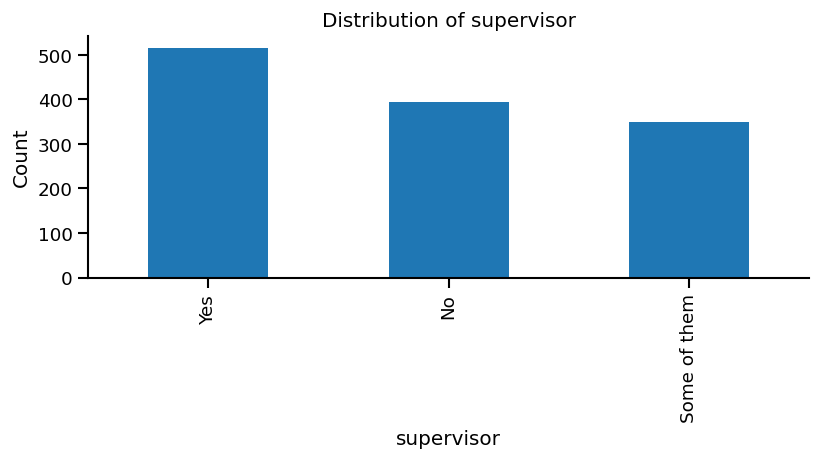

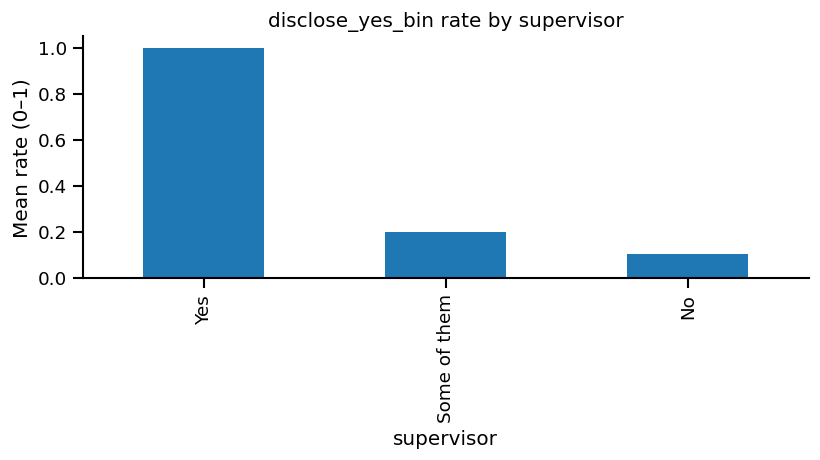


=== wellness_program ===


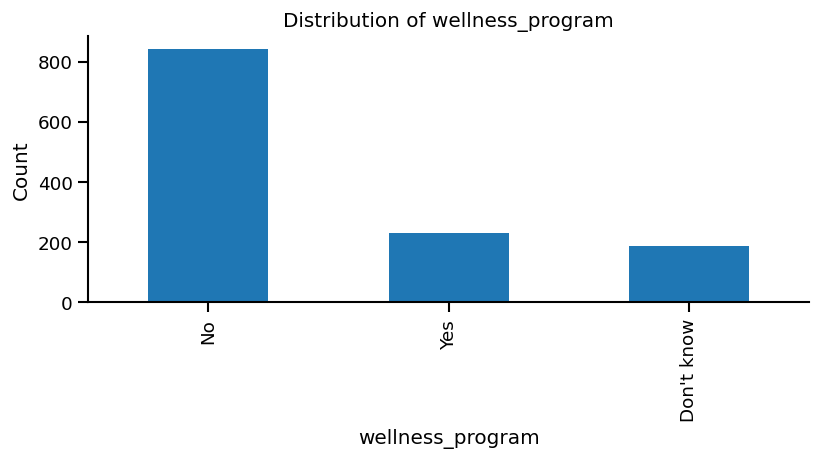

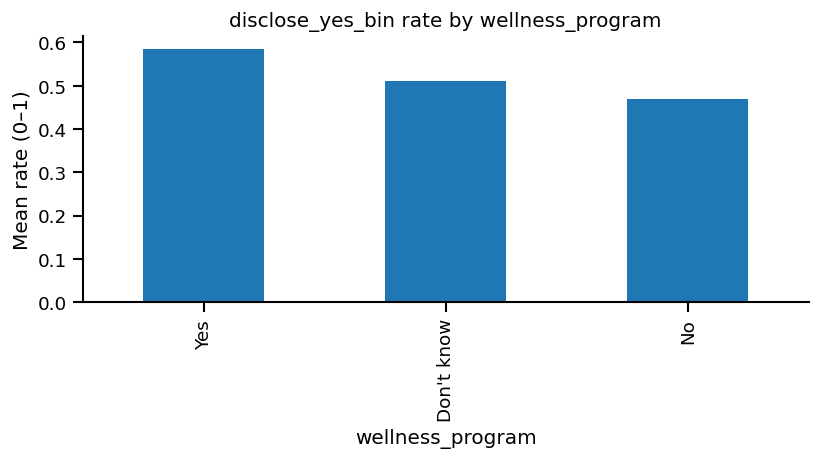

In [154]:
vars_to_plot = [
    "benefits", "anonymity", "leave", "care_options", "seek_help",
    "no_employees", "remote_work", "work_interfere",
    "coworkers", "supervisor", "wellness_program"
]
vars_to_plot = [v for v in vars_to_plot if v in df.columns]

# Use your existing helpers:
for col in vars_to_plot:
    print(f"\n=== {col} ===")
    plot_distribution(df, col)
    plot_rate(df, col, target="disclose_yes_bin")  # uses your 0/1 proxy


## Heatmap

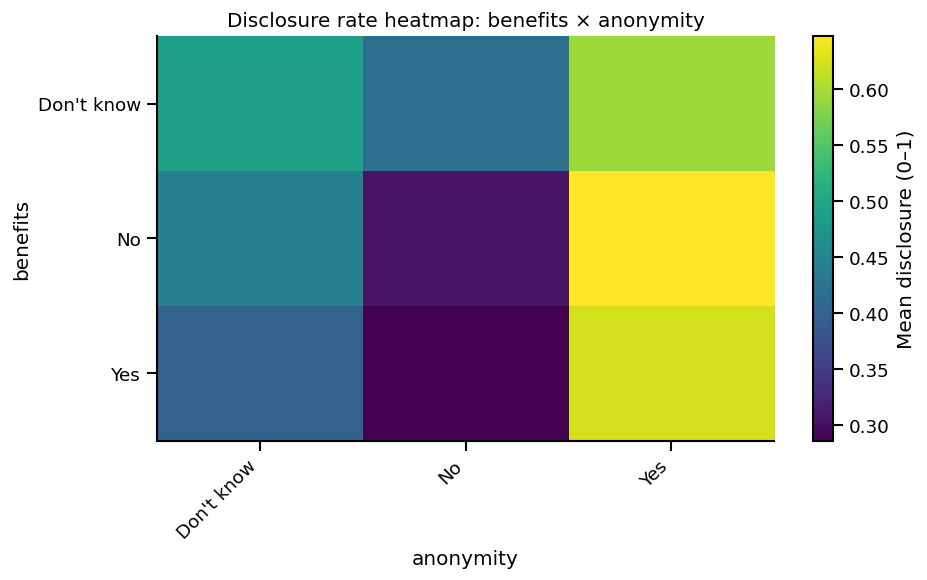

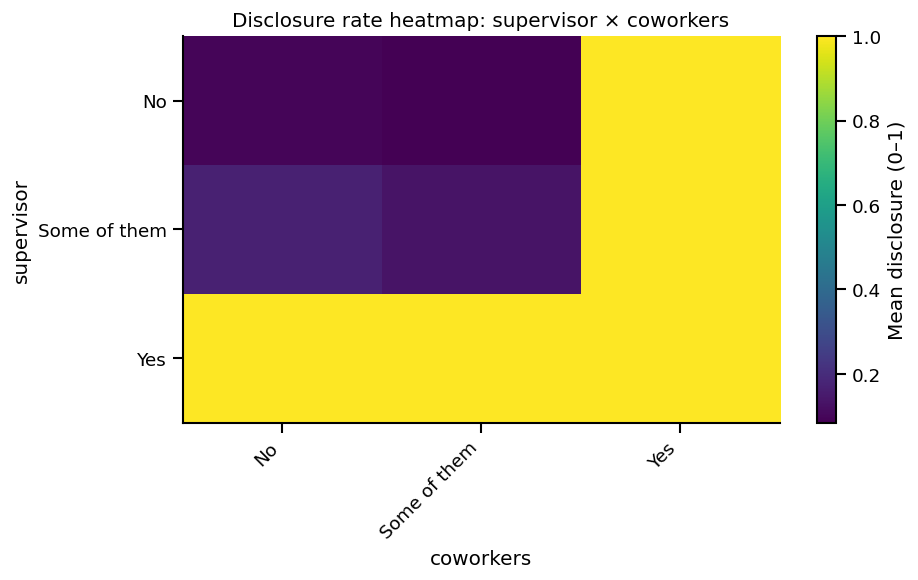

coworkers,No,Some of them,Yes
supervisor,,,
No,0.095477,0.084656,1.0
Some of them,0.170213,0.133094,1.0
Yes,1.000000,1.000000,1.0


In [155]:
def heatmap_rate(df, col_a, col_b, target=TARGET):
    d = df[[col_a, col_b, target]].dropna()
    if d.empty:
        print("(No data)"); return
    table = d.pivot_table(index=col_a, columns=col_b, values=target, aggfunc="mean")
    plt.figure(figsize=(8,5))
    plt.imshow(table, aspect="auto", interpolation="nearest")
    plt.title(f"Disclosure rate heatmap: {col_a} × {col_b}")
    plt.colorbar(label="Mean disclosure (0–1)")
    plt.ylabel(col_a)   # ← Y-axis label
    plt.xlabel(col_b)   # ← X-axis label
    plt.yticks(range(len(table.index)), table.index.astype(str))
    plt.xticks(range(len(table.columns)), table.columns.astype(str), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    return table


heatmap_rate(df, "benefits", "anonymity")
heatmap_rate(df, "supervisor", "coworkers")



In [156]:

eda_cols = [
    "disclosure_risk_label",
    "Age","age_bucket","Gender","Country",
    "benefits","anonymity","leave","leave_ord","care_options","seek_help",
    "no_employees","remote_work","work_interfere","work_interfere_ord",
    "coworkers","supervisor","wellness_program"
] + [c for c in df.columns if c.endswith("_bin")] + [c for c in ["stigma_index"] if c in df.columns]

eda_cols = [c for c in eda_cols if c in df.columns]
df[eda_cols].to_csv("data/processed/osmi_us_eda.csv", index=False)
print(f"Saved {len(eda_cols)} columns to data/processed/osmi_us_eda.csv")


Saved 18 columns to data/processed/osmi_us_eda.csv


## What Moves Disclosure? — Dot-Whisker Plot with 95% Confidence Intervals

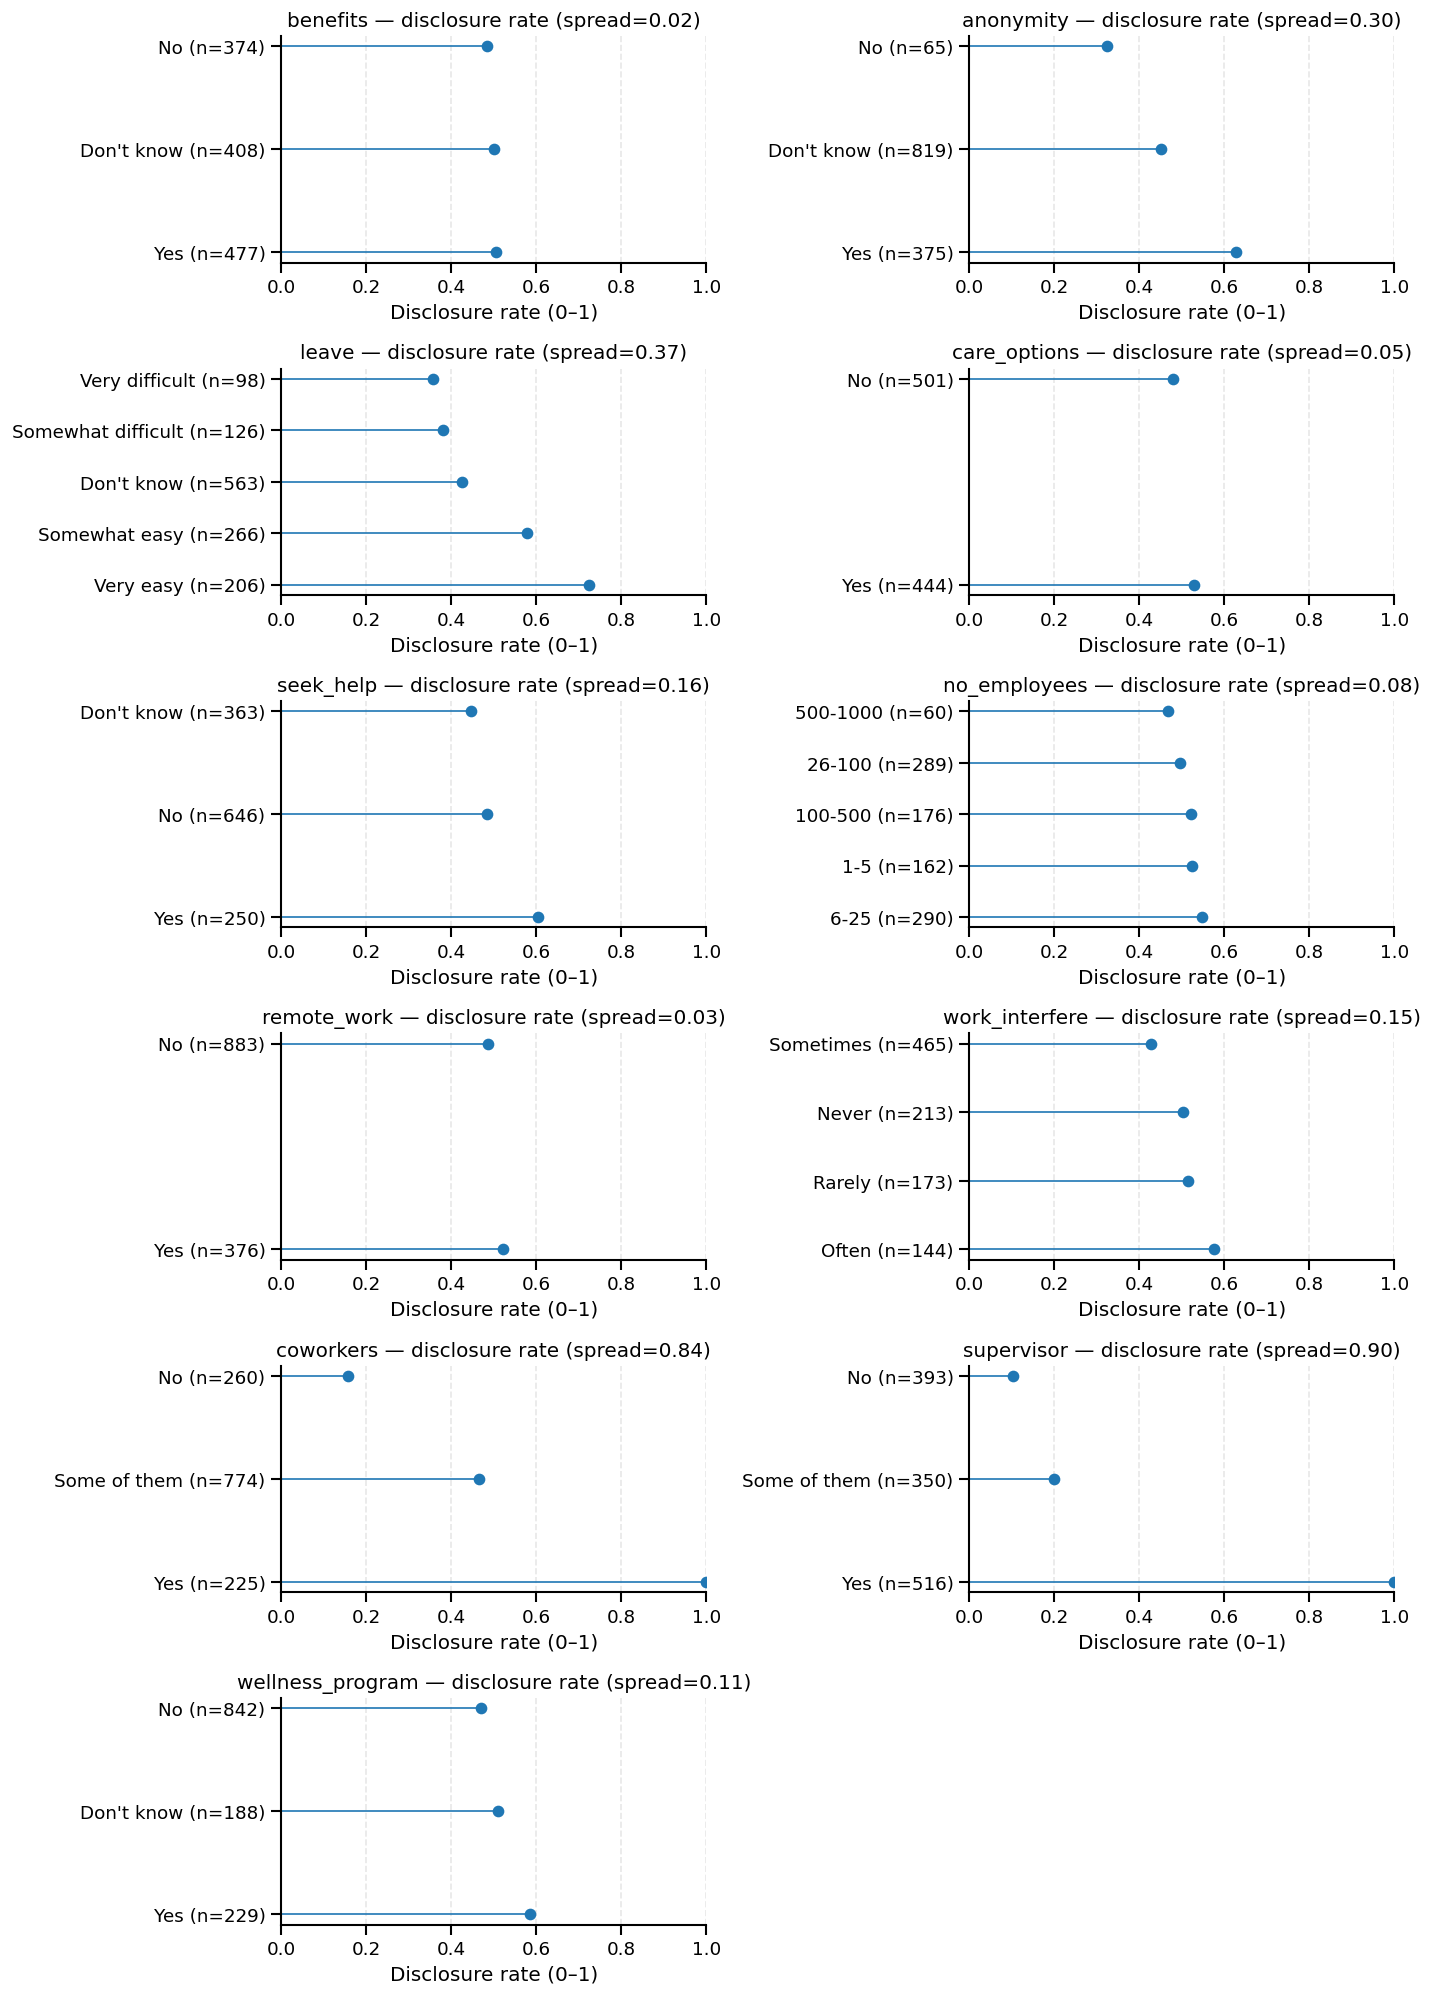

In [179]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


TARGET = "disclose_yes_bin"   


vars_to_plot = [
    "benefits", "anonymity", "leave", "care_options", "seek_help",
    "no_employees", "remote_work", "work_interfere",
    "coworkers", "supervisor", "wellness_program",
    "stigma_index_bin" ]


vars_to_plot = [v for v in vars_to_plot if v in df.columns]
vars_to_plot = [v for v in vars_to_plot if df[v].dropna().astype(str).nunique() >= 2]


assert TARGET in df.columns, f"{TARGET} not found. Create it first."

def group_rare(series, min_frac=0.01):
    vc = series.value_counts(normalize=True, dropna=False)
    rare = vc[vc < min_frac].index
    return series.where(~series.isin(rare), other="Other")

def disclosure_rates(df, col, target=TARGET):
    d = df[[col, target]].dropna()
    if d.empty:
        return None
    d[col] = group_rare(d[col].astype(str), min_frac=0.01)
    rates = d.groupby(col)[target].mean().sort_values()     # 0..1
    counts = d.groupby(col)[target].size().reindex(rates.index)
    return pd.DataFrame({"rate": rates, "n": counts})


n = len(vars_to_plot)
if n == 0:
    raise ValueError("No eligible variables found to plot.")

ncols = 2
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 2.8*nrows), squeeze=False)

for i, col in enumerate(vars_to_plot):
    r, c = divmod(i, ncols)
    ax = axes[r][c]
    tbl = disclosure_rates(df, col, target=TARGET)
    if tbl is None or tbl.empty:
        ax.axis("off")
        continue

    
    y = np.arange(len(tbl))
    ax.hlines(y, 0, tbl["rate"].values, linestyles="-", linewidth=1)
    ax.plot(tbl["rate"].values, y, "o")

    
    ax.set_yticks(y)
    
    cat_labels = [f"{idx} (n={int(n)})" for idx, n in zip(tbl.index, tbl["n"].values)]
    ax.set_yticklabels(cat_labels)
    ax.set_xlim(0, 1)
    ax.invert_yaxis()  
    ax.grid(axis="x", linestyle="--", alpha=0.3)
   fo
    spread = tbl["rate"].max() - tbl["rate"].min()
    ax.set_title(f"{col} — disclosure rate (spread={spread:.2f})")
    ax.set_xlabel("Disclosure rate (0–1)")


for j in range(i+1, nrows*ncols):
    r, c = divmod(j, ncols)
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()


In [157]:
import pandas as pd
import numpy as np


TARGET = "disclose_yes_bin"   
TOP_N  = 10                 
LOW_CARD_NUMERIC_AS_CAT = 20  


cat_cols = []
for c in df.columns:
    if df[c].dtype == "object":
        cat_cols.append(c)
    else:
        
        if df[c].nunique(dropna=True) <= LOW_CARD_NUMERIC_AS_CAT and c != TARGET:
            cat_cols.append(c)


priority = ["gender","age","no_employees","company_size","benefits","anonymity","leave",
            "care_options","seek_help","remote_work","work_interfere","coworkers","supervisor",
            "wellness_program","country","stigma_index_bin"]
ordered = [c for c in priority if c in cat_cols] + [c for c in cat_cols if c not in priority]

print(f"Found {len(ordered)} categorical-like columns.\n")


for col in ordered:
    s = df[col]
    print("\n" + "="*80)
    print(f"{col}  (dtype={s.dtype})")
    print("-"*80)

    nunique = s.nunique(dropna=True)
    miss_pct = s.isna().mean()*100
    print(f"unique (non-null): {nunique}")
    print(f"missing: {miss_pct:.1f}%")

    
    print(f"\nTop {TOP_N} categories:")
    print(s.value_counts(dropna=False).head(TOP_N).to_string())

  
    if TARGET is not None and TARGET in df.columns:
        d = df[[col, TARGET]].dropna()
        if not d.empty:
            # ensure target is numeric 0/1
            d[TARGET] = pd.to_numeric(d[TARGET], errors="coerce")
            rates = d.groupby(col)[TARGET].mean().sort_values(ascending=False)
            spread = float(rates.max() - rates.min())
            print("\nDisclosure rate by category (mean of 0/1):")
            print(rates.to_string())
            print(f"\nRate spread (max - min): {spread:.3f}")
        else:
            print("\n(No rows contain both this column and the target.)")


Found 32 categorical-like columns.


no_employees  (dtype=category)
--------------------------------------------------------------------------------
unique (non-null): 5
missing: 22.4%

Top 10 categories:
no_employees
6-25        290
26-100      289
NaN         282
100-500     176
1-5         162
500-1000     60

Disclosure rate by category (mean of 0/1):
no_employees
6-25        0.548276
1-5         0.524691
100-500     0.522727
26-100      0.494810
500-1000    0.466667

Rate spread (max - min): 0.082

benefits  (dtype=object)
--------------------------------------------------------------------------------
unique (non-null): 3
missing: 0.0%

Top 10 categories:
benefits
Yes           477
Don't know    408
No            374

Disclosure rate by category (mean of 0/1):
benefits
Yes           0.505241
Don't know    0.500000
No            0.483957

Rate spread (max - min): 0.021

anonymity  (dtype=object)
--------------------------------------------------------------------------------
uniqu

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3667381059.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = d.groupby(col)[TARGET].mean().sort_values(ascending=False)
/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3667381059.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = d.groupby(col)[TARGET].mean().sort_values(ascending=False)


## Rank Variables by impact 

In [159]:
import pandas as pd
import numpy as np

TARGET = "disclose_yes_bin"
vars_to_plot = [
    "benefits","anonymity","leave","care_options","seek_help",
    "no_employees","remote_work","work_interfere",
    "coworkers","supervisor","wellness_program"
]
vars_to_plot = [v for v in vars_to_plot if v in df.columns]

def grouped_rate(df, col, target=TARGET):
    d = df[[col, target]].dropna()
    if d.empty: 
        return None
    d[col] = d[col].astype(str)
    rates = d.groupby(col)[target].mean()
    n = d.groupby(col)[target].size()
    return pd.DataFrame({"rate": rates, "n": n}).sort_values("rate")

summary = []
tables = {}
for v in vars_to_plot:
    t = grouped_rate(df, v)
    if t is None or t.empty: 
        continue
    spread = float(t["rate"].max() - t["rate"].min())
    summary.append((v, spread, int(t["n"].sum())))
    tables[v] = t

ranked = pd.DataFrame(summary, columns=["variable","rate_spread","N"]).sort_values("rate_spread", ascending=False)
ranked.head(10)


,variable,rate_spread,N
9,supervisor,0.898219,1259
8,coworkers,0.842308,1259
2,leave,0.366158,1259
1,anonymity,0.303590,1259
4,seek_help,0.157719,1259
7,work_interfere,0.148432,995
10,wellness_program,0.114844,1259
5,no_employees,0.081609,977
3,care_options,0.050237,1259
6,remote_work,0.034300,1259


## Clean labels & set ordinal order (so lines/axes make sense)

In [160]:

ORDERS = {
    "leave": ["Very difficult","Somewhat difficult","Don't know","Somewhat easy","Very easy"],
    "no_employees": ["1-5","6-25","26-100","100-500","500-1000","More than 1000"],
    "work_interfere": ["Never","Rarely","Sometimes","Often"],
    "benefits": ["No","Don't know","Yes"],
    "anonymity": ["No","Don't know","Yes"],
    "seek_help": ["No","Don't know","Yes"],
    "care_options": ["No","Not sure","Yes"],
    "coworkers": ["No","Some of them","Yes"],
    "supervisor": ["No","Some of them","Yes"],
    "wellness_program": ["No","Don't know","Yes"],
    "remote_work": ["No","Yes"]
}

RENAMES = {
    "no_employees":"Company size",
    "work_interfere":"Work interferes with mental health",
    "care_options":"Care options known",
    "seek_help":"Seek help comfortable",
}

def apply_order_index(series, order_list):
    s = series.astype(str)
    cat = pd.Categorical(s, categories=order_list, ordered=True)
    return pd.Series(cat, index=series.index)

# Apply ordering columns that exist
for col, order in ORDERS.items():
    if col in df.columns:
        df[col] = apply_order_index(df[col], order)


## dot/lollipop plots

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3174715656.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cis = [wilson_ci(int(r*counts[i]), int(counts[i])) for i, r in enumerate(rates.values)]


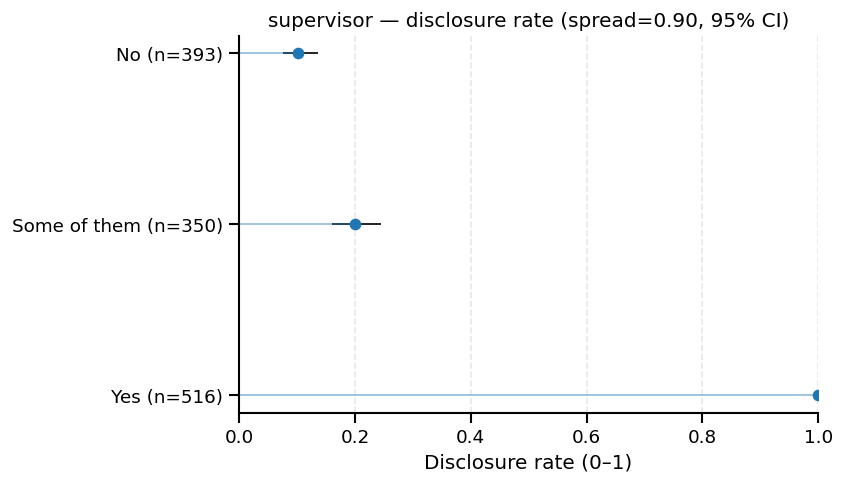

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3174715656.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cis = [wilson_ci(int(r*counts[i]), int(counts[i])) for i, r in enumerate(rates.values)]


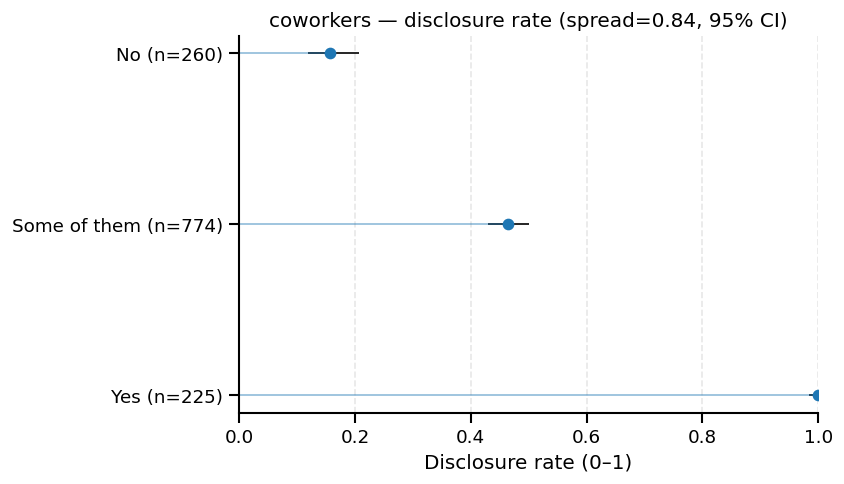

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3174715656.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cis = [wilson_ci(int(r*counts[i]), int(counts[i])) for i, r in enumerate(rates.values)]


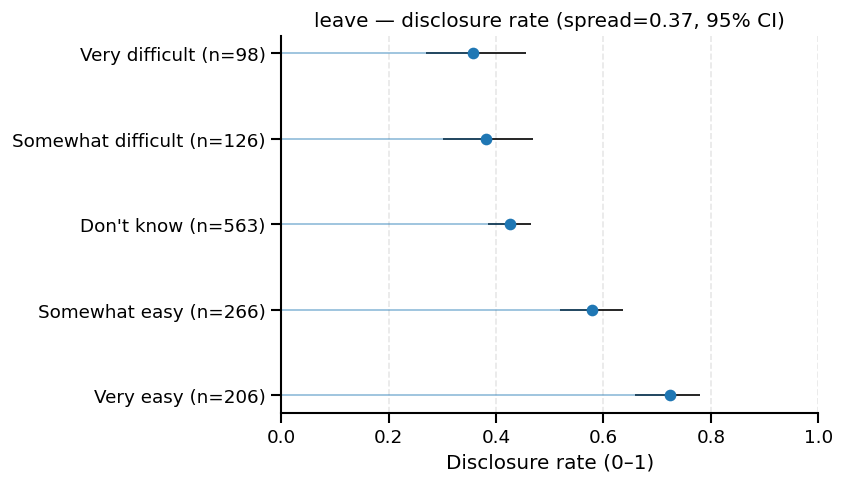

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3174715656.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cis = [wilson_ci(int(r*counts[i]), int(counts[i])) for i, r in enumerate(rates.values)]


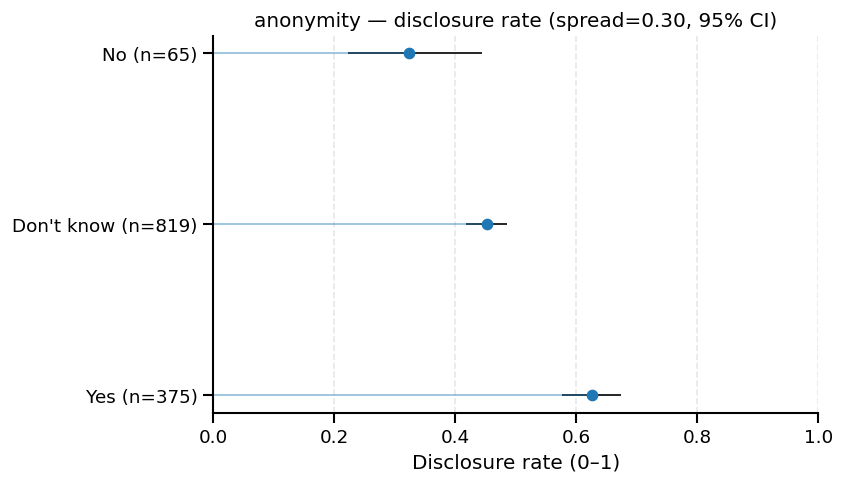

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3174715656.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cis = [wilson_ci(int(r*counts[i]), int(counts[i])) for i, r in enumerate(rates.values)]


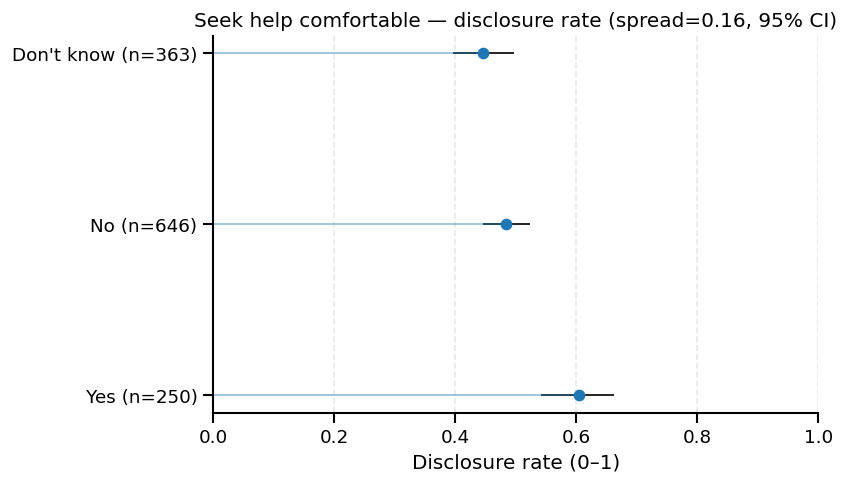

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3174715656.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cis = [wilson_ci(int(r*counts[i]), int(counts[i])) for i, r in enumerate(rates.values)]


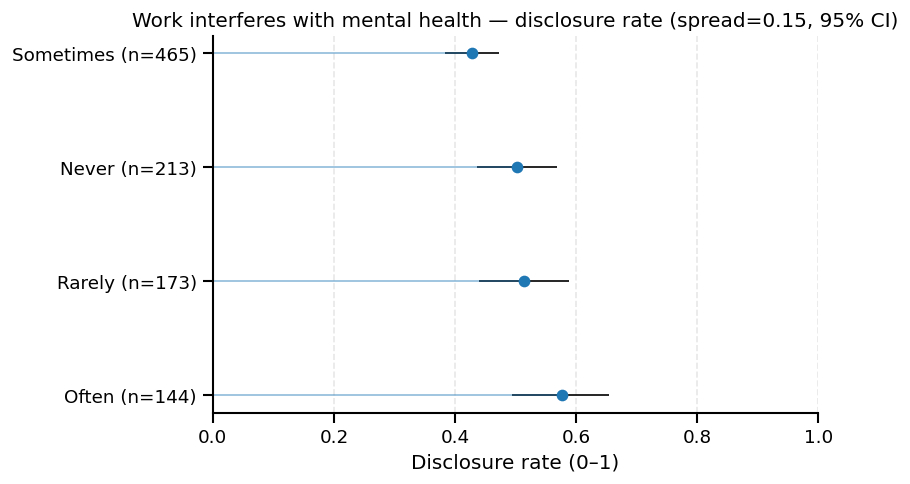

In [161]:
import matplotlib.pyplot as plt
import math

def wilson_ci(k, n, z=1.96):
    # Wilson score interval for binomial proportion
    if n == 0: return (np.nan, np.nan)
    p = k/n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half = z * math.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return center - half, center + half

def lollipop_with_ci(df, col, target=TARGET, title_override=None):
    d = df[[col, target]].dropna()
    if d.empty: 
        print(f"(No data for {col})"); 
        return
    d[col] = d[col].astype(str)
    g = d.groupby(col)[target]
    rates = g.mean().sort_values()
    counts = g.size().reindex(rates.index)

    
    cis = [wilson_ci(int(r*counts[i]), int(counts[i])) for i, r in enumerate(rates.values)]
    low = np.array([c[0] for c in cis])
    high = np.array([c[1] for c in cis])
    y = np.arange(len(rates))

    plt.figure(figsize=(7.2,4.2))
    # error bars
    plt.hlines(y, low, high, color="black", linewidth=1)
    # lollipop stems
    plt.hlines(y, 0, rates.values, linestyles="-", linewidth=1, alpha=0.5)
    # points
    plt.plot(rates.values, y, "o")

    labels = [f"{lvl} (n={int(n)})" for lvl, n in zip(rates.index, counts.values)]
    plt.yticks(y, labels)
    plt.xlim(0, 1)
    plt.gca().invert_yaxis()
    spread = rates.max() - rates.min()
    ttl = title_override or col
    plt.title(f"{RENAMES.get(ttl, ttl)} — disclosure rate (spread={spread:.2f}, 95% CI)")
    plt.xlabel("Disclosure rate (0–1)")
    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


top6 = ranked["variable"].head(6).tolist()
for v in top6:
    lollipop_with_ci(df, v)


In [162]:
def disclosure_rate_by(col):
    tmp = (df.groupby(col)["disclose_yes"]
             .apply(lambda s: (s=="Yes").mean())
             .sort_values(ascending=False)
             .reset_index(name="disclosure_rate"))
    return tmp

tables = {}

# Gender
if "gender" in df.columns:
    tables["by_gender"] = disclosure_rate_by("gender")
    print("\nDisclosure by gender:")
    print(tables["by_gender"].head(10))

# Company size
if size_col:
    tables["by_company_size"] = disclosure_rate_by(size_col)
    print("\nDisclosure by company size:")
    print(tables["by_company_size"])

# Benefits / anonymity / care options
for key in ["benefit","anonym","care_option","seek","leave"]:
    cands = [c for c in df.columns if key in c]
    if cands:
        col = cands[0]
        tables[f"by_{key}"] = disclosure_rate_by(col)
        print(f"\nDisclosure by {col}:")
        print(tables[f"by_{key}"].head(10))


Disclosure by company size:
     no_employees  disclosure_rate
0            6-25         0.548276
1             1-5         0.524691
2         100-500         0.522727
3          26-100         0.494810
4        500-1000         0.466667
5  More than 1000              NaN

Disclosure by benefits:
     benefits  disclosure_rate
0         Yes         0.505241
1  Don't know         0.500000
2          No         0.483957

Disclosure by anonymity:
    anonymity  disclosure_rate
0         Yes         0.626667
1  Don't know         0.451770
2          No         0.323077

Disclosure by care_options:
  care_options  disclosure_rate
0          Yes         0.529279
1           No         0.479042
2     Not sure              NaN

Disclosure by seek_help:
    seek_help  disclosure_rate
0         Yes         0.604000
1          No         0.484520
2  Don't know         0.446281

Disclosure by leave:
                leave  disclosure_rate
0           Very easy         0.723301
1       Somewhat eas

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3783258676.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = (df.groupby(col)["disclose_yes"]
/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3783258676.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = (df.groupby(col)["disclose_yes"]
/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/3783258676.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futur

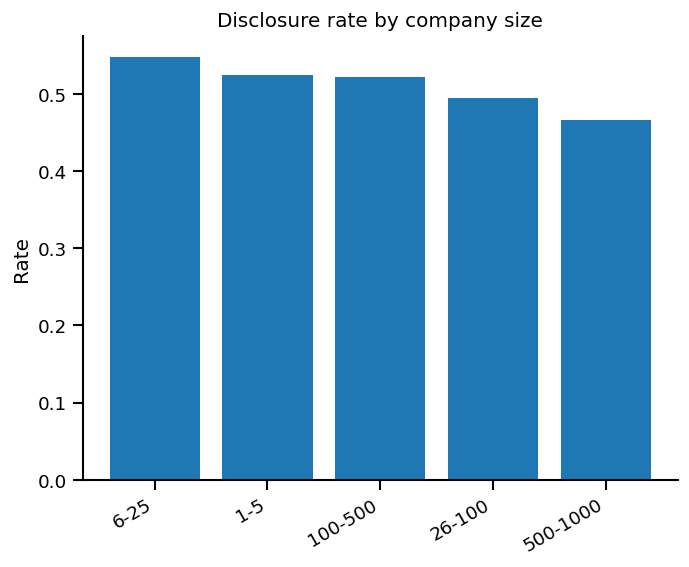

In [163]:
# One chart at a time (matplotlib, no custom colors)

# Example: Top 6 gender groups by disclosure rate
if "by_gender" in locals() or "tables" in locals():
    t = tables.get("by_gender")
    if t is not None and not t.empty:
        t2 = t.head(6)
        plt.figure()
        plt.bar(t2["gender"].astype(str), t2["disclosure_rate"])
        plt.title("Disclosure rate by gender (top 6)")
        plt.xticks(rotation=30, ha="right")
        plt.ylabel("Rate")
        plt.show()

# Example: Company size by disclosure rate
t = tables.get("by_company_size")
if t is not None and not t.empty:
    plt.figure()
    plt.bar(t.iloc[:,0].astype(str), t["disclosure_rate"])
    plt.title("Disclosure rate by company size")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Rate")
    plt.show()

## Setup & Helper Functions — Imports, Plot Style, TARGET, Bootstrap CI & Rate Table

In [164]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
sns.set_context("talk")

"
TARGET = "disclose_yes_bin"


assert TARGET in df.columns, f"Target column '{TARGET}' not found in df."


def _prop_ci_bootstrap(success, total, B=1000, seed=42):
    """Bootstrap 95% CI for a proportion based on Bernoulli resampling."""
    if total == 0:
        return np.nan, (np.nan, np.nan)
    p = success / total
    rng = np.random.default_rng(seed)
    draws = rng.binomial(n=total, p=p, size=B) / total
    lo, hi = np.percentile(draws, [2.5, 97.5])
    return p, (lo, hi)

def _rate_table(df, by, target=TARGET, dropna=True, order=None, label_map=None):
    """Compute disclosure rate and 95% CI by a categorical column."""
    if by not in df.columns:
        return pd.DataFrame(columns=[by, "n", "rate", "ci_lo", "ci_hi"])
    d = df[[by, target]].copy()
    if dropna:
        d = d.dropna(subset=[by, target])
    if label_map:
        d[by] = d[by].map(label_map).fillna(d[by])
    grp = d.groupby(by, dropna=False)
    rows = []
    for k, g in grp:
        n = len(g)
        suc = g[target].sum()
        p, (lo, hi) = _prop_ci_bootstrap(suc, n)
        rows.append({by: k, "n": n, "rate": p, "ci_lo": lo, "ci_hi": hi})
    out = pd.DataFrame(rows)
    # order handling
    if order is not None:
        out[by] = pd.Categorical(out[by], categories=order, ordered=True)
        out = out.sort_values(by)
    else:
        out = out.sort_values("rate", ascending=False)
    return out.reset_index(drop=True)

def _percent_fmt(x):
    return f"{100*x:.1f}%"


## Lollipop with 95% CIs (single-factor rates)

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)
/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)
/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

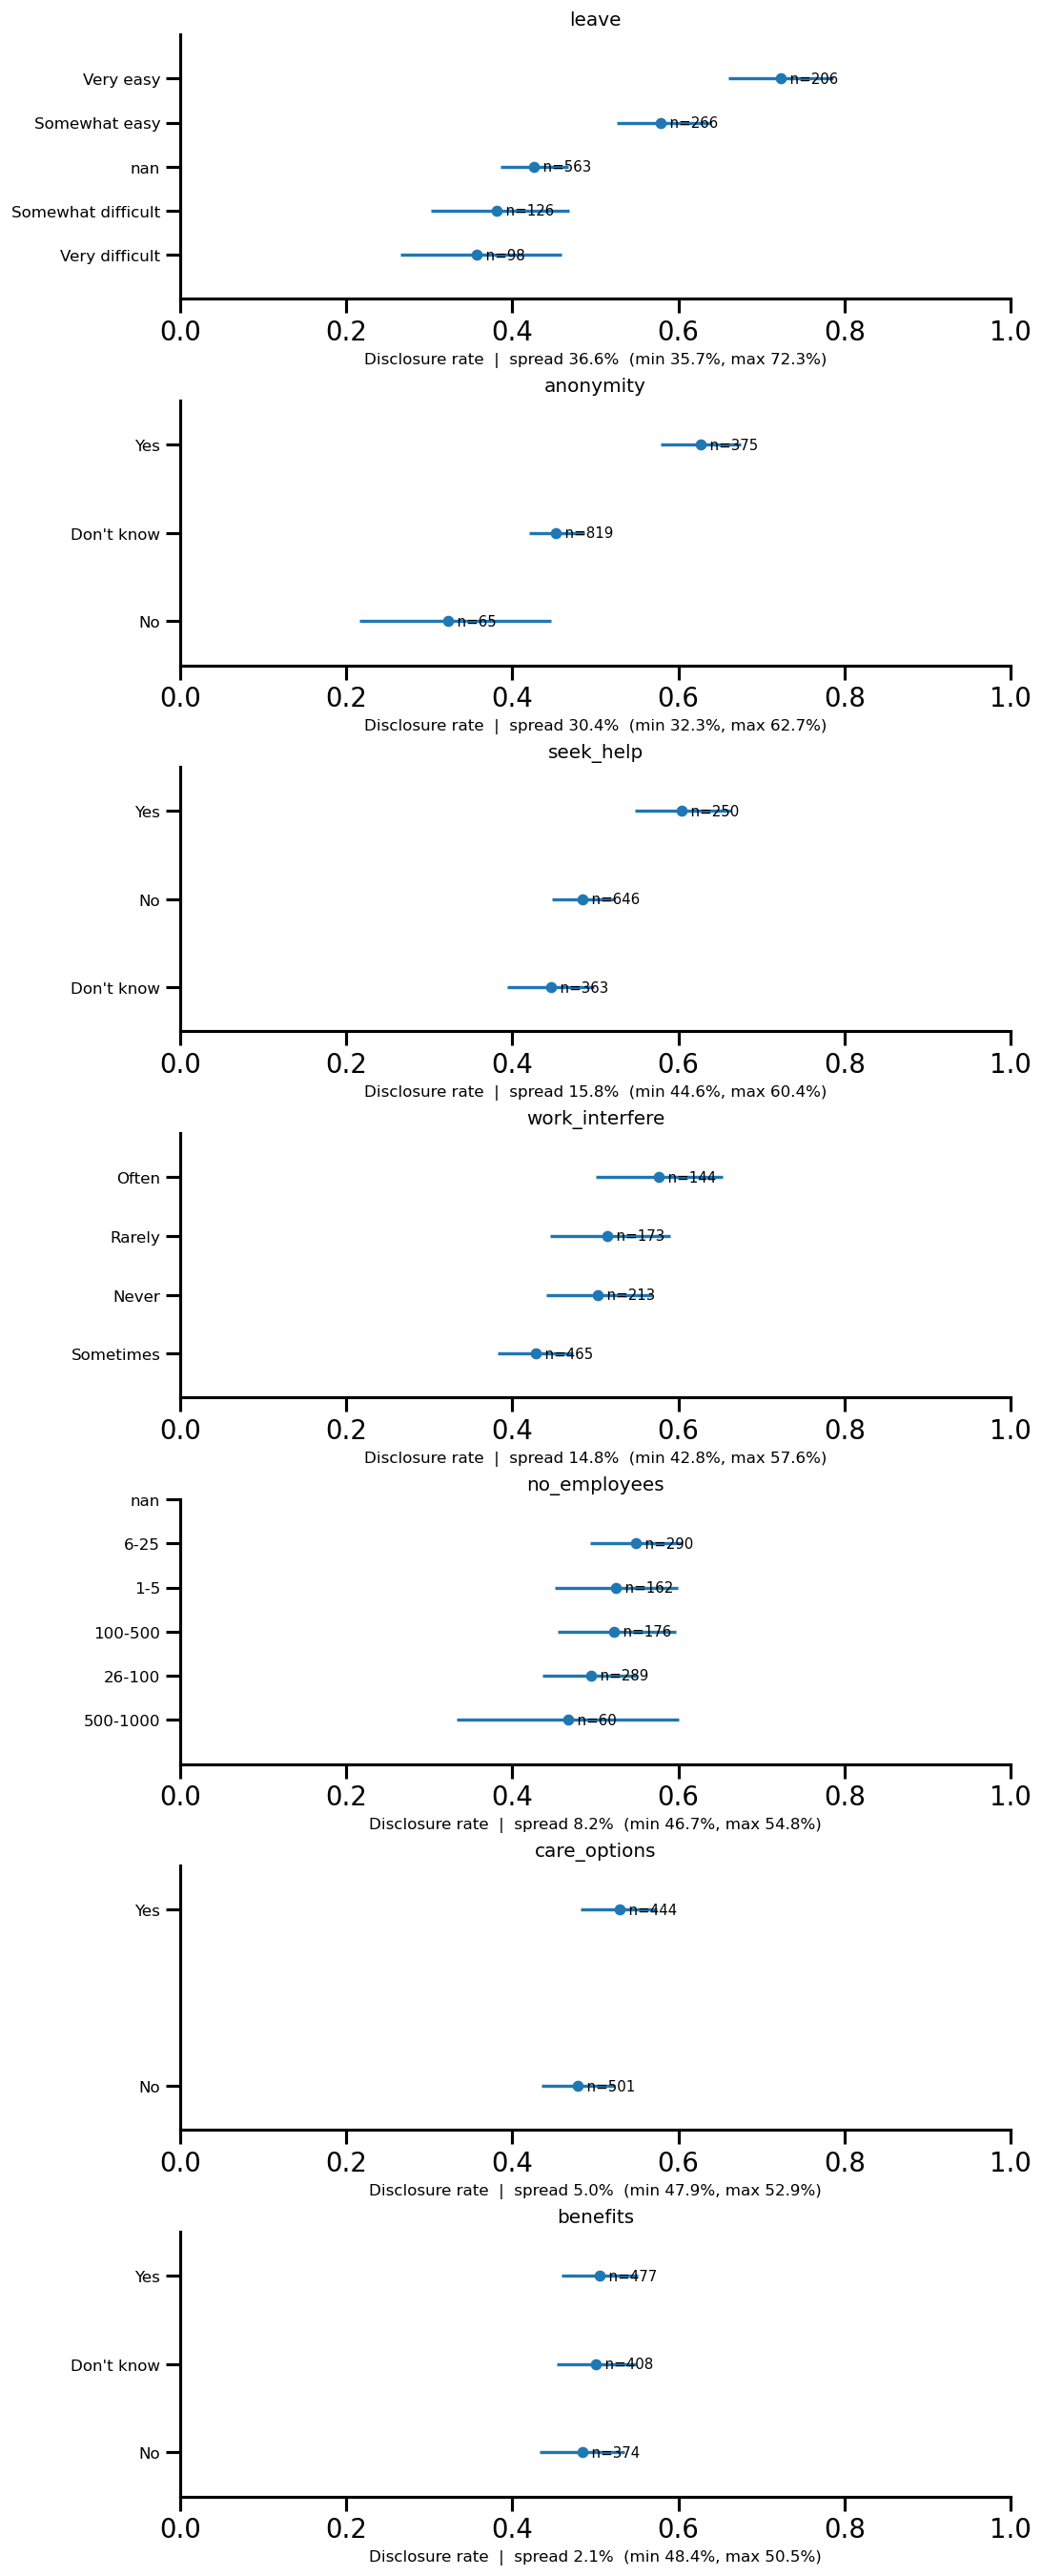

In [165]:

features = [
    ("leave",       ["Very easy","Somewhat easy","Neutral","Somewhat difficult","Very difficult"]),
    ("anonymity",   None),
    ("benefits",    None),
    ("care_options",None),
    ("seek_help",   None),
    ("work_interfere", ["Never","Rarely","Sometimes","Often"]),
    ("no_employees", ["1-5","6-25","26-100","100-500","500-1000","1000-5000","5000-10000","10000+"])
]

# Build a long frame of category-level rates and a summary spread per feature
rows = []
summary = []
for col, order in features:
    if col not in df.columns:
        print(f"(skip) '{col}' not in df")
        continue
    rt = _rate_table(df, col, order=order)
    rt["feature"] = col
    rows.append(rt)
    if len(rt) >= 2:
        spread = rt["rate"].max() - rt["rate"].min()
        summary.append({"feature": col, "spread": spread, "min": rt["rate"].min(), "max": rt["rate"].max()})

rates_long = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
summary_df = pd.DataFrame(summary).sort_values("spread", ascending=False)

# --- Replace the plotting block in the lollipop cell with this ---
if not summary_df.empty:
    per_panel_h = 3.2  # increase panel height
    fig, axes = plt.subplots(
        nrows=len(summary_df),
        ncols=1,
        figsize=(9, per_panel_h * len(summary_df)),
        sharex=False,
        constrained_layout=True  # better than tight_layout for subplots
    )

    # slightly smaller global text than "talk"
    import seaborn as sns
    sns.set_context("notebook")

    if len(summary_df) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, summary_df.iterrows()):
        feat = row["feature"]
        sub = rates_long[rates_long["feature"] == feat].sort_values("rate", ascending=True)
        y = np.arange(len(sub))
        ax.hlines(y, sub["ci_lo"], sub["ci_hi"], lw=2)
        ax.plot(sub["rate"], y, "o")
        ax.set_yticks(y)
        ax.set_yticklabels(sub[feat].astype(str), fontsize=10)
        # keep titles short; move details to x-label
        ax.set_title(f"{feat}", fontsize=12, pad=6)
        ax.set_xlabel(
            f"Disclosure rate  |  spread {_percent_fmt(row['spread'])}  "
            f"(min {_percent_fmt(row['min'])}, max {_percent_fmt(row['max'])})",
            fontsize=10
        )
        # leave vertical margin so points/labels don't clip
        ax.margins(y=0.25)
        ax.set_xlim(0, 1)

        # n labels
        for yi, (r, n) in enumerate(zip(sub["rate"], sub["n"])):
            ax.text(r, yi, f"  n={n}", va="center", ha="left", fontsize=9)

    # extra breathing room if needed
    plt.subplots_adjust(hspace=0.5)
    plt.show()
else:
    print("No features available to plot.")



/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1517065210.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = d.pivot_table(index=row_col, columns=col_col, values=target, aggfunc="mean")


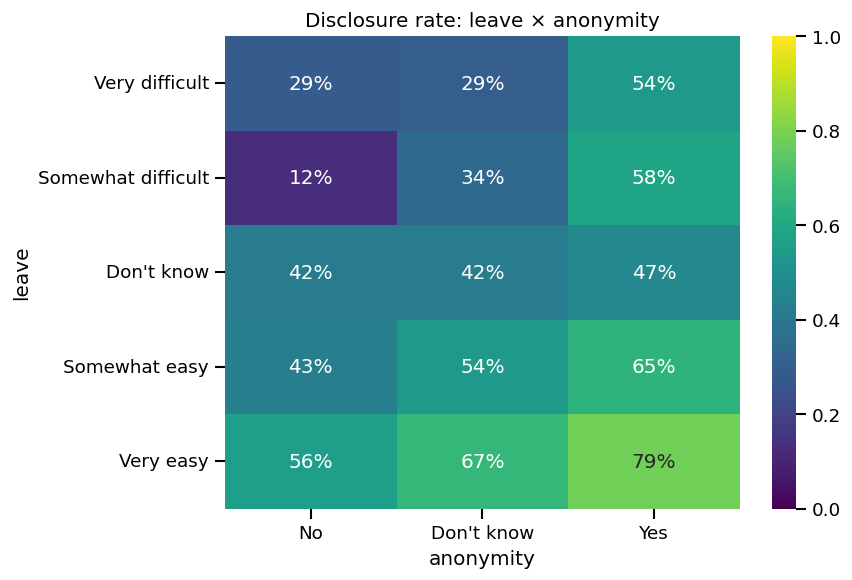

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1517065210.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = d.pivot_table(index=row_col, columns=col_col, values=target, aggfunc="mean")


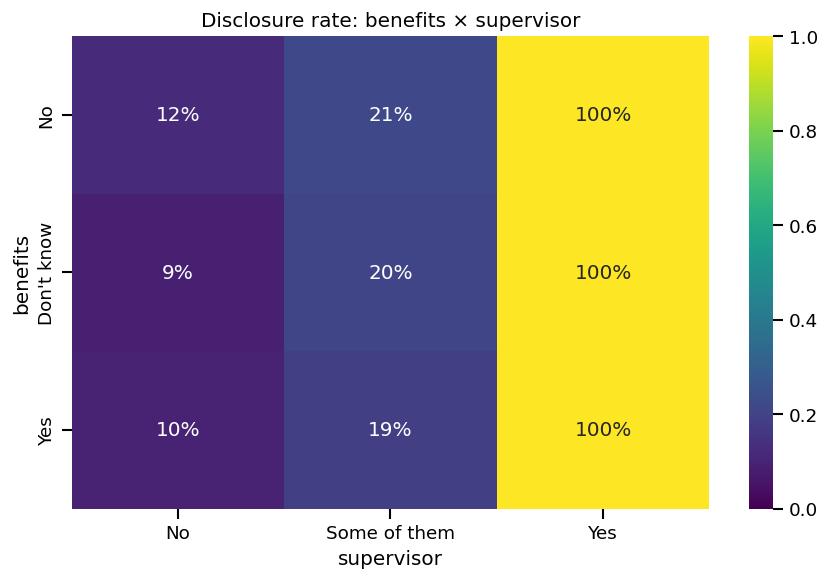

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1517065210.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = d.pivot_table(index=row_col, columns=col_col, values=target, aggfunc="mean")


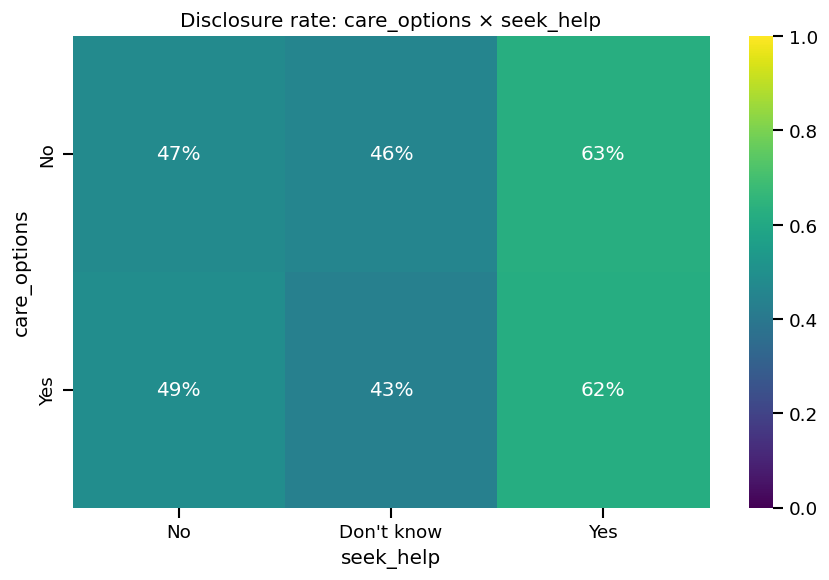

In [166]:

def two_way_heatmap(df, row_col, col_col, target=TARGET, title=None, annot=True, fmt=".0%"):
    if row_col not in df.columns or col_col not in df.columns:
        print(f"(skip) Missing column(s): {row_col}, {col_col}")
        return
    d = df[[row_col, col_col, target]].dropna(subset=[row_col, col_col])
    piv = d.pivot_table(index=row_col, columns=col_col, values=target, aggfunc="mean")
    plt.figure(figsize=(7.5, 5))
    sns.heatmap(piv, cmap="viridis", vmin=0, vmax=1, annot=annot, fmt=fmt)
    ttl = title or f"Disclosure rate: {row_col} × {col_col}"
    plt.title(ttl)
    plt.ylabel(row_col); plt.xlabel(col_col)
    plt.tight_layout()
    plt.show()


two_way_heatmap(df, "leave", "anonymity", title="Disclosure rate: leave × anonymity")
two_way_heatmap(df, "benefits", "supervisor", title="Disclosure rate: benefits × supervisor")
two_way_heatmap(df, "care_options", "seek_help", title="Disclosure rate: care_options × seek_help")


## Slopegraph: coworkers vs supervisor (Yes / Some / No

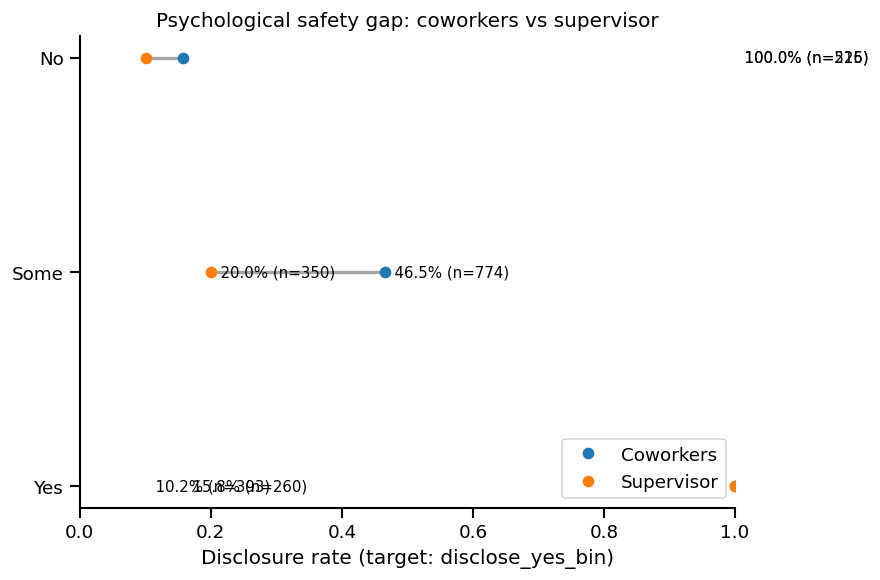

In [167]:

def slopegraph_coworker_supervisor(df, cowork_col="coworkers", sup_col="supervisor", target=TARGET):
    if cowork_col not in df.columns or sup_col not in df.columns:
        print(f"(skip) Missing columns: {cowork_col} or {sup_col}")
        return

    
    label_map = {"Some of them":"Some", "Sometimes":"Some"}
    left = _rate_table(df, cowork_col, target, label_map=label_map)
    left[cowork_col] = left[cowork_col].astype(str)
    right = _rate_table(df, sup_col, target, label_map=label_map)
    right[sup_col] = right[sup_col].astype(str)

    
    order = ["Yes","Some","No"]
    merged = pd.merge(left.rename(columns={"rate":"cowork_rate","n":"n_cow"}),
                      right.rename(columns={"rate":"sup_rate","n":"n_sup"}),
                      left_on=cowork_col, right_on=sup_col, how="outer")
    
    merged["label"] = merged[cowork_col].fillna(merged[sup_col])
    merged = merged[merged["label"].isin(order)].copy()
    merged["label"] = pd.Categorical(merged["label"], order, ordered=True)
    merged = merged.sort_values("label")

   
    plt.figure(figsize=(7.5, 5))
    y = np.arange(len(merged))
    plt.hlines(y, merged["cowork_rate"], merged["sup_rate"], color="gray", lw=2, alpha=0.7)
    plt.plot(merged["cowork_rate"], y, "o", label="Coworkers")
    plt.plot(merged["sup_rate"],   y, "o", label="Supervisor")
    for yi, row in merged.iterrows():
        plt.text(row["cowork_rate"], y[yi], f"  {_percent_fmt(row['cowork_rate'])} (n={int(row['n_cow'] or 0)})",
                 va="center", ha="left", fontsize=9)
        plt.text(row["sup_rate"], y[yi], f"  {_percent_fmt(row['sup_rate'])} (n={int(row['n_sup'] or 0)})",
                 va="center", ha="left", fontsize=9)
    plt.yticks(y, merged["label"])
    plt.xlabel(f"Disclosure rate (target: {TARGET})")
    plt.title("Psychological safety gap: coworkers vs supervisor")
    plt.xlim(0, 1)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

slopegraph_coworker_supervisor(df)


## Company size profile

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)


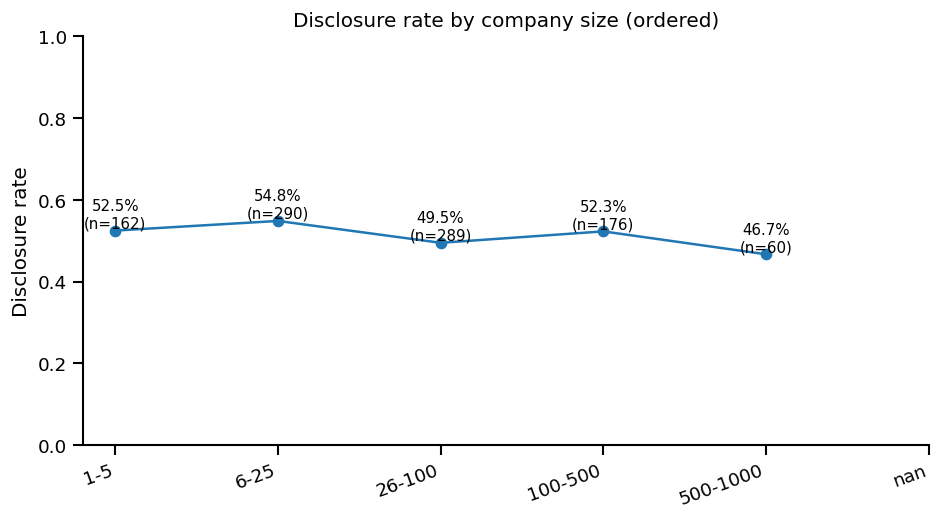

In [168]:

def company_size_profile(df, size_col="no_employees", target=TARGET,
                         order=("1-5","6-25","26-100","100-500","500-1000","1000-5000","5000-10000","10000+")):
    if size_col not in df.columns:
        print(f"(skip) Missing column: {size_col}")
        return
    rt = _rate_table(df, size_col, target, order=list(order))
    plt.figure(figsize=(8,4.5))
    plt.plot(rt["rate"], marker="o")
    plt.xticks(range(len(rt)), rt[size_col].astype(str), rotation=20, ha="right")
    for i, (r, n) in enumerate(zip(rt["rate"], rt["n"])):
        plt.text(i, r, f"{_percent_fmt(r)}\n(n={n})", ha="center", va="bottom", fontsize=9)
    plt.ylim(0, 1)
    plt.ylabel("Disclosure rate")
    plt.title("Disclosure rate by company size (ordered)")
    plt.tight_layout()
    plt.show()

company_size_profile(df)


## Age Profile

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)
/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)
/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

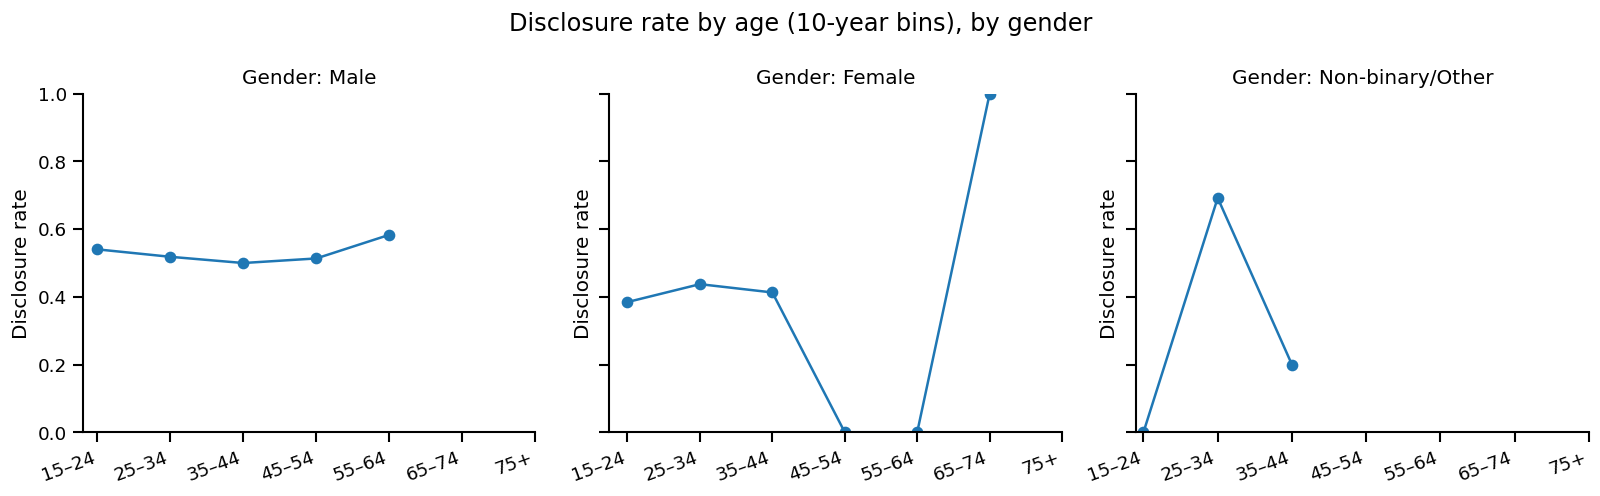

In [169]:

def age_profile(df, age_col="Age", gender_col="Gender", target=TARGET, split_by_gender=True):
    if age_col not in df.columns:
        print(f"(skip) Missing column: {age_col}")
        return

    d = df[[age_col, target] + ([gender_col] if split_by_gender and gender_col in df.columns else [])].dropna(subset=[age_col])
    # 10-year bins (customize if you already have age_bucket)
    bins = list(range(15, 76, 10)) + [120]  # 15-24, 25-34, ..., 75+
    labels = [f"{bins[i]}–{bins[i+1]-1}" if i < len(bins)-2 else f"{bins[i]}+" for i in range(len(bins)-1)]
    d["age_bin10"] = pd.cut(d[age_col], bins=bins, labels=labels, include_lowest=True, right=True)

    if split_by_gender and gender_col in d.columns:
        glevels = d[gender_col].dropna().value_counts().index[:3]  # keep top 3
        fig, axes = plt.subplots(1, len(glevels), figsize=(4.5*len(glevels), 4.2), sharey=True)
        if len(glevels) == 1:
            axes = [axes]
        for ax, g in zip(axes, glevels):
            sub = d[d[gender_col] == g]
            rt = _rate_table(sub, "age_bin10", target, order=labels)
            ax.plot(rt["rate"], marker="o")
            ax.set_xticks(range(len(rt)))
            ax.set_xticklabels(rt["age_bin10"].astype(str), rotation=20, ha="right")
            ax.set_ylim(0,1); ax.set_title(f"{gender_col}: {g}")
            ax.set_ylabel("Disclosure rate")
        fig.suptitle("Disclosure rate by age (10-year bins), by gender")
        plt.tight_layout()
        plt.show()
    else:
        rt = _rate_table(d, "age_bin10", target, order=labels)
        plt.figure(figsize=(8,4.2))
        plt.plot(rt["rate"], marker="o")
        plt.xticks(range(len(rt)), rt["age_bin10"].astype(str), rotation=20, ha="right")
        plt.ylim(0,1); plt.ylabel("Disclosure rate")
        plt.title("Disclosure rate by age (10-year bins)")
        plt.tight_layout(); plt.show()

age_profile(df, split_by_gender=True)  # set False if you do not want small multiples


## Who answered what & disclosure rate (95% CI) — <col>

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)


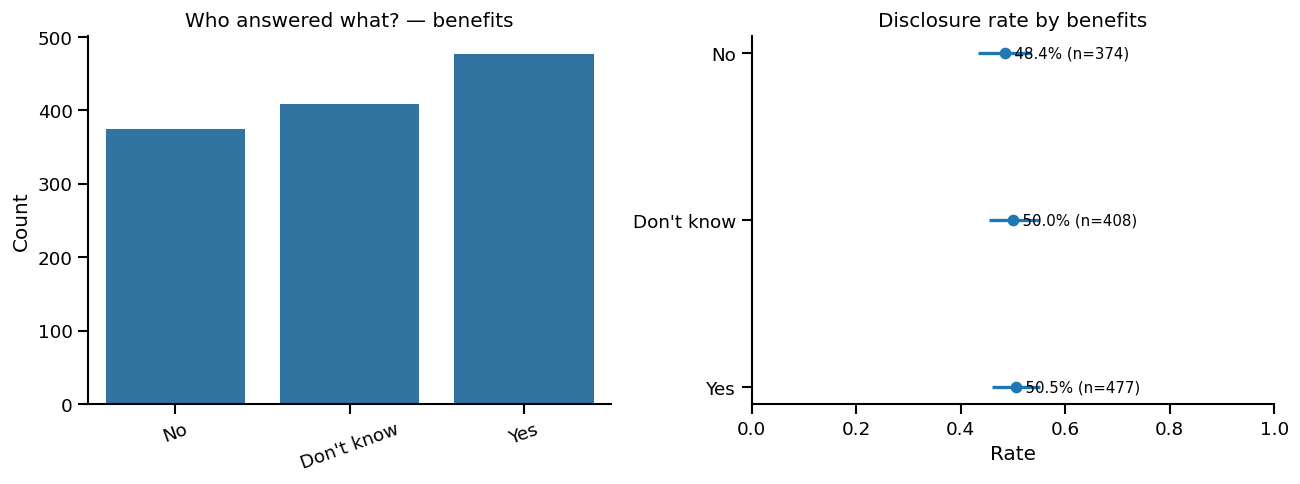

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)


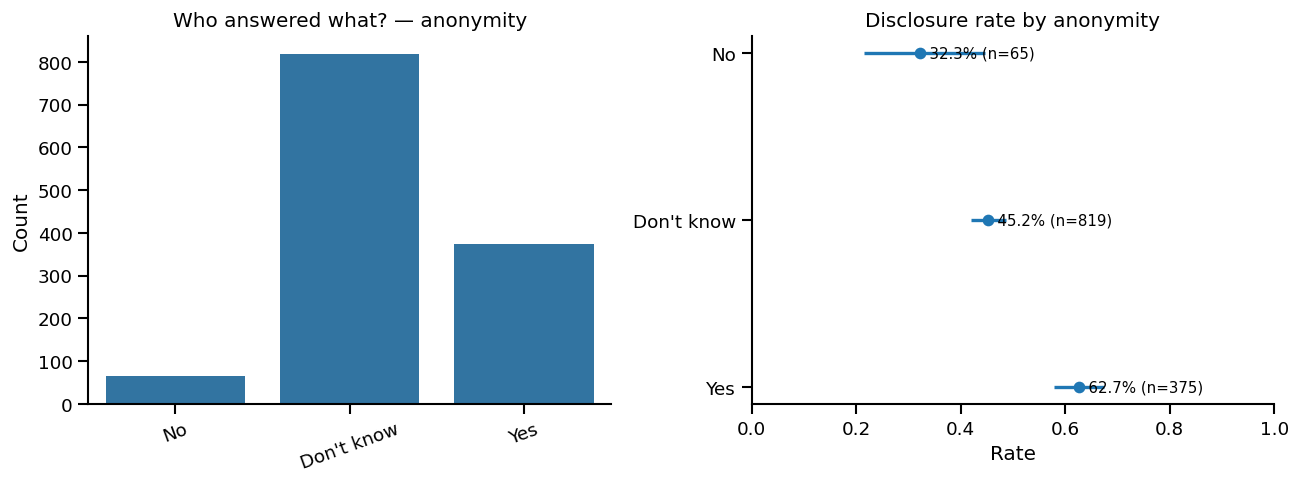

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)


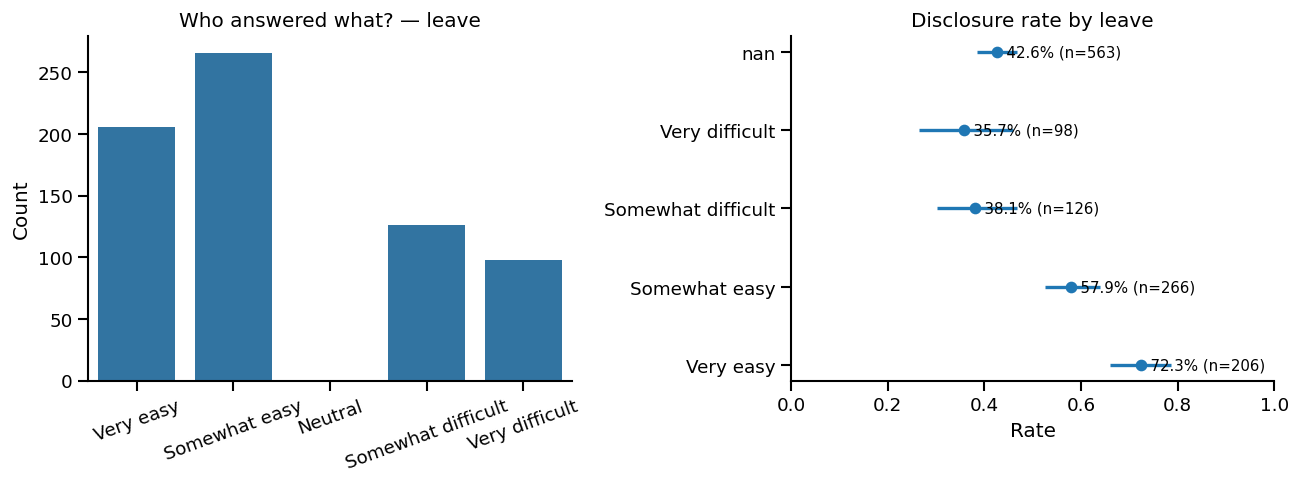

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)


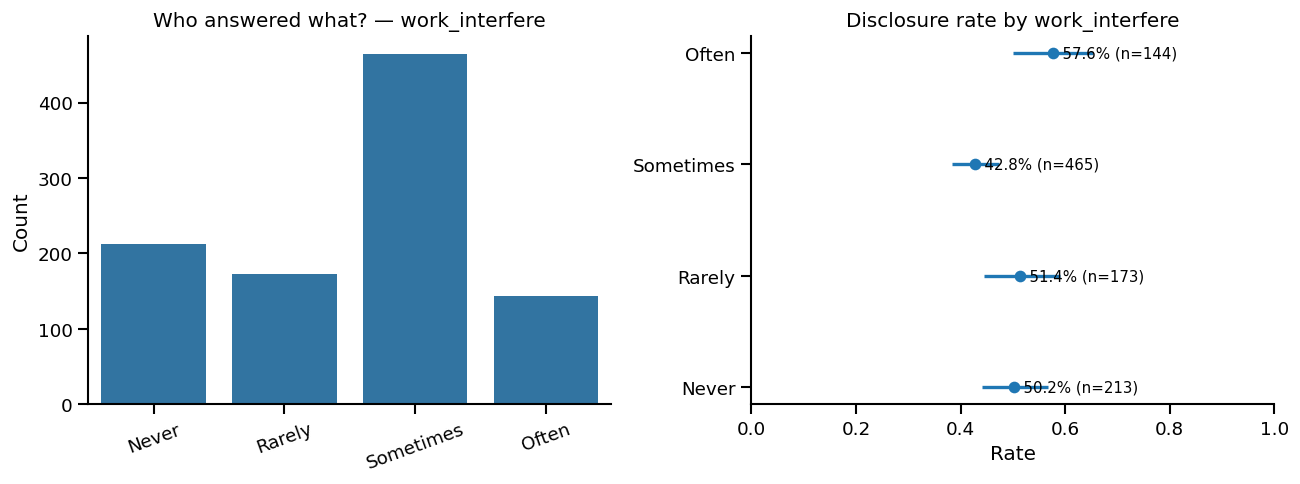

/var/folders/vx/g_hb6nyx08n286vxnwpxcsch0000gn/T/ipykernel_69818/1658990919.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(by, dropna=False)


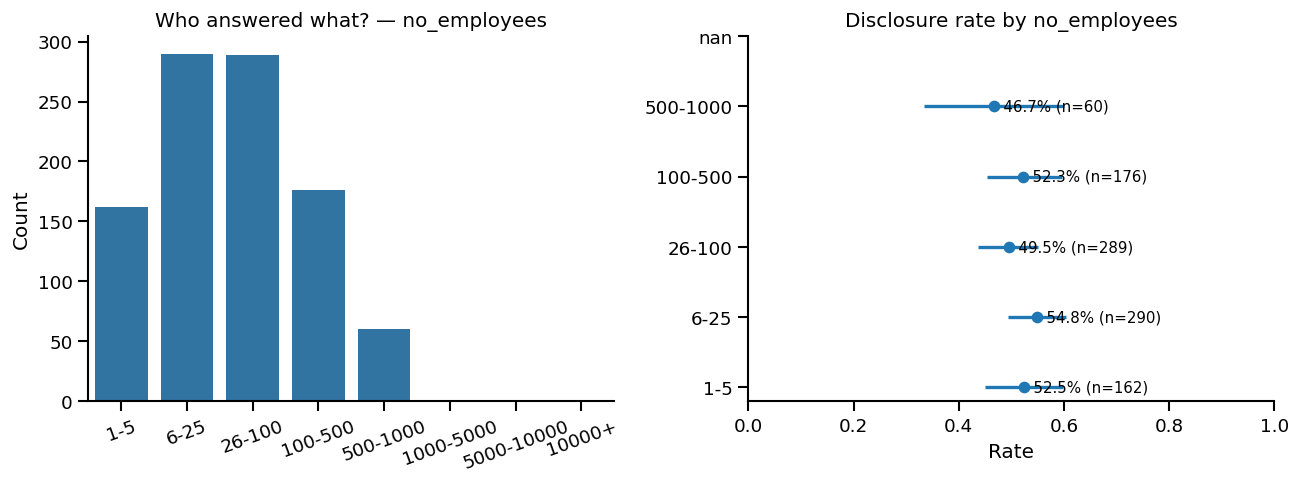

In [177]:

def dist_and_rate(df, col, target=TARGET, order=None):
    if col not in df.columns:
        print(f"(skip) Missing column: {col}")
        return
    d = df[[col, target]].dropna(subset=[col])
    counts = d[col].value_counts(dropna=False).rename_axis(col).reset_index(name='count')
    if order:
        counts[col] = pd.Categorical(counts[col], categories=order, ordered=True)
        counts = counts.sort_values(col)
    rt = _rate_table(d, col, target, order=order)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), sharey=False)
    
    sns.barplot(data=counts, x=col, y="count", ax=axes[0])
    axes[0].set_title(f"Who answered what? — {col}")
    axes[0].set_xlabel(""); axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', rotation=20)

   
    axes[1].hlines(range(len(rt)), rt["ci_lo"], rt["ci_hi"], lw=2)
    axes[1].plot(rt["rate"], range(len(rt)), "o")
    axes[1].set_yticks(range(len(rt)))
    axes[1].set_yticklabels(rt[col].astype(str))
    axes[1].set_title(f"Disclosure rate by {col}")
    axes[1].set_xlabel("Rate"); axes[1].set_xlim(0,1)

    
    for yi, (r, n) in enumerate(zip(rt["rate"], rt["n"])):
        axes[1].text(r, yi, f"  {_percent_fmt(r)} (n={n})", va="center", ha="left", fontsize=9)

    plt.tight_layout(); plt.show()


dist_and_rate(df, "benefits")
dist_and_rate(df, "anonymity")
dist_and_rate(df, "leave", order=["Very easy","Somewhat easy","Neutral","Somewhat difficult","Very difficult"])
dist_and_rate(df, "work_interfere", order=["Never","Rarely","Sometimes","Often"])
dist_and_rate(df, "no_employees", order=["1-5","6-25","26-100","100-500","500-1000","1000-5000","5000-10000","10000+"])


In [173]:
encoded = {}

# 1) Ordinal encodings
encoded["ordinal"] = [c for c in df.columns if c.endswith("_ord")]

encoded["binary_helpers"] = [c for c in df.columns if c.endswith("_bin")]

# 3) Cleaned Y/N fields (standardized labels)
yn_cols = ["benefits","anonymity","care_options","seek_help",
           "remote_work","coworkers","supervisor","wellness_program"]
encoded["yn_cleaned"] = [c for c in yn_cols if c in df.columns]

# 4) Target labels (not features, but useful to list)
encoded["targets"] = [c for c in ["disclose_yes_bin","disclosure_risk_label","disclose_yes"] if c in df.columns]

# 5) One-hot at model time (can't see expanded columns until you fit/transform),
#    so we just report if you defined a ColumnTransformer with OneHotEncoder in your code.
import re, inspect, sys

# Create a copy of globals to avoid modifying during iteration
globals_copy = dict(globals())
src = ""
for name, obj in globals_copy.items():
    try:
        if "OneHotEncoder" in inspect.getsource(obj):
            src += f"\n{name} contains OneHotEncoder"
    except Exception:
        pass
encoded["one_hot_pipeline_defined"] = bool(src)

print("=== Encodings Found ===")
for k, v in encoded.items():
    print(f"{k}: {v}")


=== Encodings Found ===
ordinal: ['leave_ord', 'work_interfere_ord']
binary_helpers: ['has_condition_bin', 'disclose_yes_bin']
yn_cleaned: ['benefits', 'anonymity', 'care_options', 'seek_help', 'remote_work', 'coworkers', 'supervisor', 'wellness_program']
targets: ['disclose_yes_bin', 'disclosure_risk_label', 'disclose_yes']
one_hot_pipeline_defined: False


## Encoding Audit: What Got Encoded & How (now with One-Hot pipeline)

In [176]:

TARGET = "disclose_yes_bin"


num_cols = [c for c in ["stigma_index", "Age"] if c in df.columns]


ord_cols = [c for c in ["leave_ord", "work_interfere_ord"] if c in df.columns]


cat_candidates = ["anonymity","benefits","care_options","seek_help",
                  "no_employees","coworkers","supervisor","Gender","country","remote_work","wellness_program"]
cat_cols = [c for c in cat_candidates if c in df.columns]


exclude_cols = {"disclose_yes_bin", "disclosure_risk_label", "disclose_yes",
                "has_condition", "has_condition_bin"}
cat_cols = [c for c in cat_cols if c not in exclude_cols]

print("num_cols:", num_cols)
print("ord_cols:", ord_cols)
print("cat_cols:", cat_cols)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

ord_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent"))
])  # ordinals are already numeric (1..k)


cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # Changed 'sparse' to 'sparse_output'
])



preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("ord", ord_pipe, ord_cols),
    ("cat", cat_pipe, cat_cols),
])


from sklearn.utils import Bunch
X = df[num_cols + ord_cols + cat_cols].copy()
X_small = X.head(5)
Xt = preprocess.fit_transform(X_small)
print("Transformed shape (5 rows):", Xt.shape)


try:
    ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
    cat_names = ohe.get_feature_names_out(cat_cols)
    print("First 10 OHE feature names:", list(cat_names[:10]))
except Exception as e:
    print("Feature names not available:", e)


num_cols: ['Age']
ord_cols: ['leave_ord', 'work_interfere_ord']
cat_cols: ['anonymity', 'benefits', 'care_options', 'seek_help', 'no_employees', 'coworkers', 'supervisor', 'Gender', 'country', 'remote_work', 'wellness_program']
Transformed shape (5 rows): (5, 31)
First 10 OHE feature names: ["anonymity_Don't know", 'anonymity_No', 'anonymity_Yes', "benefits_Don't know", 'benefits_No', 'benefits_Yes', 'care_options_No', 'care_options_Yes', "seek_help_Don't know", 'seek_help_No']
